## Housing Project: Advanced Regression Techniques

#### In this supervised learning project, I will employ feature engineering and various regression techniques in order to predict housing prices. 

#### First, I load the necessary libraries and examine the data:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skewtest
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split


In [16]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [17]:
train_data.shape

(1460, 81)

In [18]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [19]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Step 1: Data cleaning

### 1.1: Checking for NaNs

#### A big part of data cleaning is dealing with NaN entries, and deciding whether/how to replace or remove them.

#### First, I create a function to check which columns contain NaN entries

In [20]:
def check_nans(data):
    """Checks data for NaN entries
    Inputs: Pandas Dataframe
    Outputs: Columns containing NaN entries"""
    
    nan_cols = []
    for col in data.columns:
        if data[col].isnull().values.any():
            nan_cols.append(col)
    return nan_cols

In [22]:
check_nans(train_data), check_nans(test_data)

(['LotFrontage',
  'Alley',
  'MasVnrType',
  'MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'FireplaceQu',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PoolQC',
  'Fence',
  'MiscFeature'],
 ['MSZoning',
  'LotFrontage',
  'Alley',
  'Utilities',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinSF1',
  'BsmtFinType2',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  'BsmtFullBath',
  'BsmtHalfBath',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageCars',
  'GarageArea',
  'GarageQual',
  'GarageCond',
  'PoolQC',
  'Fence',
  'MiscFeature',
  'SaleType'])

#### Here I create a function to display the data types of a list of columns in the dataset provided as an argument:

In [23]:
def check_data_types(data,col_list):
    for col in col_list:
        print(f"Column name: {col}, Data type: {data[col].dtype}")

#### I also separate the target variable from, the predictor variable, and then combine the train and test features for the purpose of cleaning the data

In [24]:
y_train = train_data['SalePrice']

In [26]:
train_data = train_data.drop('SalePrice',axis=1)

In [105]:
alldata = train_data.append(test_data)

In [106]:
check_data_types(alldata,check_nans(alldata))

Column name: MSZoning, Data type: object
Column name: LotFrontage, Data type: float64
Column name: Alley, Data type: object
Column name: Utilities, Data type: object
Column name: Exterior1st, Data type: object
Column name: Exterior2nd, Data type: object
Column name: MasVnrType, Data type: object
Column name: MasVnrArea, Data type: float64
Column name: BsmtQual, Data type: object
Column name: BsmtCond, Data type: object
Column name: BsmtExposure, Data type: object
Column name: BsmtFinType1, Data type: object
Column name: BsmtFinSF1, Data type: float64
Column name: BsmtFinType2, Data type: object
Column name: BsmtFinSF2, Data type: float64
Column name: BsmtUnfSF, Data type: float64
Column name: TotalBsmtSF, Data type: float64
Column name: Electrical, Data type: object
Column name: BsmtFullBath, Data type: float64
Column name: BsmtHalfBath, Data type: float64
Column name: KitchenQual, Data type: object
Column name: Functional, Data type: object
Column name: FireplaceQu, Data type: object


In [107]:
alldata = alldata.reset_index().iloc[:,1:]

#### Now, I go through every column in the data that contains NaNs. If the data is numeric, I can employ a skew test to determine whether the mean or median is better suited to replace the NaNs (the median is more suitable for skewed data).

#### For categorical data, the modal label will replace the missing entries.

#### This is quite a lengthy process, but it's important that the values we impute are those that are the least likely to misrepresent the data, and that we don't hastily discard columns that may provide valuable insight.

In [108]:
alldata['MSZoning'].value_counts(dropna=False)

RL         2265
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: MSZoning, dtype: int64

In [109]:
mode = alldata['MSZoning'].value_counts().index[0]

alldata['MSZoning'] = alldata['MSZoning'].fillna(mode)

In [110]:
alldata['LotFrontage'].value_counts(dropna=False)

NaN      486
60.0     276
80.0     137
70.0     133
50.0     117
        ... 
138.0      1
31.0       1
144.0      1
141.0      1
28.0       1
Name: LotFrontage, Length: 129, dtype: int64

In [111]:
p = skewtest(alldata['LotFrontage'],nan_policy='omit')

if p[1] < 0.05:
    alldata['LotFrontage'] = alldata['LotFrontage'].fillna(alldata['LotFrontage'].median())
else:
    alldata['LotFrontage'] = alldata['LotFrontage'].fillna(alldata['LotFrontage'].mean())

In [112]:
alldata['Alley'].value_counts(dropna=False)

NaN     2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [113]:
alldata['Alley'] = alldata['Alley'].fillna('None')

In [114]:
alldata['Utilities'].value_counts(dropna=False)

AllPub    2916
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64

In [115]:
alldata['Utilities'] = alldata['Utilities'].fillna('AllPub')

In [116]:
alldata['Exterior1st'].value_counts(dropna=False)

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
NaN           1
ImStucc       1
Name: Exterior1st, dtype: int64

In [117]:
alldata['Exterior1st'] = alldata['Exterior1st'].fillna('VinylSd')

In [118]:
alldata['Exterior2nd'].value_counts(dropna=False)

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
NaN           1
Name: Exterior2nd, dtype: int64

In [119]:
alldata['Exterior2nd'] = alldata['Exterior2nd'].fillna('VinylSd')

In [120]:
alldata['MasVnrType'].value_counts(dropna=False)

None       1742
BrkFace     879
Stone       249
BrkCmn       25
NaN          24
Name: MasVnrType, dtype: int64

In [121]:
alldata[['MasVnrType','MasVnrArea']][alldata[['MasVnrType','MasVnrArea']].isna().any(axis=1)]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN
1691,NaN,NaN
1706,NaN,NaN


In [122]:
alldata.loc[2610,'MasVnrType'] = 'BrkFace'

In [123]:
alldata['MasVnrType'] = alldata['MasVnrType'].fillna('None')

In [124]:
alldata['MasVnrArea'].value_counts(dropna=False)

0.0       1738
NaN         23
120.0       15
200.0       13
176.0       13
          ... 
571.0        1
207.0        1
34.0         1
550.0        1
1159.0       1
Name: MasVnrArea, Length: 445, dtype: int64

In [125]:
alldata['MasVnrArea'] = alldata['MasVnrArea'].fillna(0.0)

In [126]:
alldata[['MasVnrType','MasVnrArea']][(alldata['MasVnrArea'] > 0) &  (alldata['MasVnrType'] == 'None')]

,MasVnrType,MasVnrArea
624,None,288.0
773,None,1.0
1230,None,1.0
1300,None,344.0
1334,None,312.0
1669,None,285.0
2452,None,1.0


In [127]:
for i in [624,773,1230,1300,1334,1669,2452]:
    alldata.loc[i,'MasVnrArea'] = 0.0

In [128]:
alldata[['MasVnrType','MasVnrArea']][(alldata['MasVnrArea'] == 0) &  (alldata['MasVnrType'] != 'None')]

,MasVnrType,MasVnrArea
688,BrkFace,0.0
1241,Stone,0.0
2319,BrkFace,0.0


In [129]:
for i in [688,1241,2319]:
    alldata.loc[i,'MasVnrType'] = 'None'

In [130]:
alldata['BsmtQual'].value_counts(dropna=False)

TA     1283
Gd     1209
Ex      258
Fa       88
NaN      81
Name: BsmtQual, dtype: int64

In [131]:
alldata['BsmtCond'].value_counts(dropna=False)

TA     2606
Gd      122
Fa      104
NaN      82
Po        5
Name: BsmtCond, dtype: int64

In [132]:
alldata['BsmtExposure'].value_counts(dropna=False)

No     1904
Av      418
Gd      276
Mn      239
NaN      82
Name: BsmtExposure, dtype: int64

In [133]:
alldata['BsmtFinType1'].value_counts(dropna=False)

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
NaN     79
Name: BsmtFinType1, dtype: int64

In [134]:
alldata['TotalBsmtSF'].value_counts(dropna=False)

0.0       78
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
494.0      1
551.0      1
1154.0     1
105.0      1
1570.0     1
Name: TotalBsmtSF, Length: 1059, dtype: int64

In [135]:
alldata[['BsmtCond','TotalBsmtSF']][(alldata['BsmtCond'].isna()) & (alldata['TotalBsmtSF'] > 0)]

,BsmtCond,TotalBsmtSF
2040,NaN,1426.0
2185,NaN,1127.0
2524,NaN,995.0


In [136]:
for i in [2040,2185,2524]:
    alldata.loc[i,'BsmtCond'] = 'TA'

In [137]:
alldata[['BsmtExposure','TotalBsmtSF']][(alldata['BsmtExposure'].isna()) & (alldata['TotalBsmtSF'] > 0)]

,BsmtExposure,TotalBsmtSF
948,NaN,936.0
1487,NaN,1595.0
2348,NaN,725.0


In [138]:
for i in [948,1487,2348]:
    alldata.loc[i,'BsmtExposure'] = 'No'

In [139]:
alldata[['BsmtQual','TotalBsmtSF']][(alldata['BsmtQual'].isna()) & (alldata['TotalBsmtSF'] > 0)]

,BsmtQual,TotalBsmtSF
2217,NaN,173.0
2218,NaN,356.0


In [140]:
for i in [2217,2218]:
    alldata.loc[i,'BsmtQual'] = 'TA'

In [141]:
alldata['BsmtCond'] = alldata['BsmtCond'].fillna('None')
alldata['BsmtQual'] = alldata['BsmtQual'].fillna('None')
alldata['BsmtExposure'] = alldata['BsmtExposure'].fillna('None')
alldata['BsmtFinType1'] = alldata['BsmtFinType1'].fillna('None')


In [142]:
alldata['Electrical'].value_counts(dropna=False)

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [143]:
alldata['Electrical'] = alldata['Electrical'].fillna('SBrkr')

In [144]:
alldata['BsmtFullBath'].value_counts(dropna=False)

0.0    1705
1.0    1172
2.0      38
NaN       2
3.0       2
Name: BsmtFullBath, dtype: int64

In [145]:
alldata['BsmtFullBath'] = alldata['BsmtFullBath'].fillna(0.0)

In [146]:
alldata['BsmtFinSF1'][alldata['BsmtFinSF1'].isna()]

2120   NaN
Name: BsmtFinSF1, dtype: float64

In [147]:
alldata.loc[2120,'BsmtFinSF1'] = 0
alldata.loc[2120,'BsmtFinSF2'] = 0
alldata.loc[2120,'TotalBsmtSF'] = 0
alldata.loc[2120,'BsmtUnfSF'] = 0


In [148]:
alldata[['TotalBsmtSF','BsmtFinType2']][alldata['BsmtFinType2'].isna() & (alldata['TotalBsmtSF'] > 0)]

,TotalBsmtSF,BsmtFinType2
332,3206.0,NaN


In [149]:
alldata.loc[332,'BsmtFinType2'] = 'Unf'

In [150]:
alldata['BsmtFinType2'] = alldata['BsmtFinType2'].fillna('None')

In [151]:
alldata['BsmtHalfBath'].value_counts(dropna=False)

0.0    2742
1.0     171
2.0       4
NaN       2
Name: BsmtHalfBath, dtype: int64

In [152]:
alldata['BsmtHalfBath'] = alldata['BsmtHalfBath'].fillna(0.0)

In [ ]:
all_features['BsmtFinSF1'][all_features['BsmtFinSF1'].isna()]

In [ ]:
all_features['BsmtFinSF2'][all_features['BsmtFinSF2'].isna()]

In [ ]:
all_features['TotalBsmtSF'][all_features['TotalBsmtSF'].isna()]

In [ ]:
all_features['BsmtUnfSF'][all_features['BsmtUnfSF'].isna()]

In [ ]:
all_features.loc[2120,'BsmtQual']

In [ ]:
all_features['BsmtFinType2'].value_counts(dropna=False)

In [ ]:
all_features[['TotalBsmtSF','BsmtFinType2']][all_features['BsmtFinType2'].isna() & (all_features['TotalBsmtSF'] > 0)]

In [ ]:
all_features.loc[332,'BsmtFinType2'] = 'Unf'

In [ ]:
all_features['BsmtFinType2'] = all_features['BsmtFinType2'].fillna('None')

In [ ]:
all_features.loc[2120,'BsmtFinSF1'] = 0
all_features.loc[2120,'BsmtFinSF2'] = 0
all_features.loc[2120,'TotalBsmtSF'] = 0
all_features.loc[2120,'BsmtUnfSF'] = 0

In [ ]:
all_features['BsmtHalfBath'].value_counts(dropna=False)

In [ ]:
all_features['BsmtHalfBath'] = all_features['BsmtHalfBath'].fillna('0.0')

In [ ]:
all_features['KitchenQual'].value_counts(dropna=False)

In [ ]:
all_features['KitchenQual'] = all_features['KitchenQual'].fillna('TA')

In [ ]:
all_features['Functional'].value_counts(dropna=False)

In [ ]:
all_features['Functional'] = all_features['Functional'].fillna('Typ')

In [ ]:
all_features['FireplaceQu'].value_counts(dropna=False)

In [ ]:
all_features['FireplaceQu'] = all_features['FireplaceQu'].fillna('None')

In [ ]:
all_features['GarageType'].value_counts(dropna=False)

In [ ]:
all_features['GarageYrBlt'].value_counts(dropna=False)

In [ ]:
all_features['GarageFinish'].value_counts(dropna=False)

In [ ]:
all_features['GarageCars'].value_counts(dropna=False)

In [ ]:
all_features['GarageQual'].value_counts(dropna=False)

In [ ]:
all_features['GarageCond'].value_counts(dropna=False)

In [ ]:
all_features[['GarageType','GarageFinish','GarageQual','GarageCond','GarageCars']][all_features['GarageCars'].isna()]

In [ ]:
all_features.loc[2576,'GarageFinish'] = 'Unf'
all_features.loc[2576,'GarageQual'] = 'TA'
all_features.loc[2576,'GarageCond'] = 'TA'
all_features.loc[2576,'GarageCars'] = 2.0

In [ ]:
all_features['GarageCars']

In [ ]:
all_features[['GarageType','GarageFinish','GarageQual','GarageCond','GarageCars']][(all_features['GarageCars'] > 0) & 
                                                                                   (all_features['GarageCond'].isna())]

In [ ]:
all_features.loc[2126,'GarageFinish'] = 'Unf'
all_features.loc[2126,'GarageQual'] = 'TA'
all_features.loc[2126,'GarageCond'] = 'TA'

In [ ]:
all_features['GarageFinish'] = all_features['GarageFinish'].fillna('None')
all_features['GarageQual'] = all_features['GarageQual'].fillna('None')
all_features['GarageCond'] = all_features['GarageCond'].fillna('None')
all_features['GarageType'] = all_features['GarageType'].fillna('None')

In [ ]:
all_features = all_features.drop('GarageYrBlt',axis=1)

In [ ]:
all_features['GarageArea'][all_features['GarageArea'].isna()]

In [ ]:
p = skewtest(all_features['GarageArea'],nan_policy='omit')

if p[1] < 0.05:
    all_features['GarageArea'] = all_features['GarageArea'].fillna(all_features['GarageArea'].median())
else:
    all_features['GarageArea'] = all_features['GarageArea'].fillna(all_features['GarageArea'].mean())

In [ ]:
all_features['PoolQC'].value_counts(dropna=False)

In [ ]:
all_features['PoolQC'] = all_features['PoolQC'].fillna('None')

In [ ]:
all_features['Fence'].value_counts(dropna=False)

In [ ]:
all_features['Fence'] = all_features['Fence'].fillna('None')

In [ ]:
all_features['MiscFeature'].value_counts(dropna=False)

In [ ]:
all_features['MiscFeature'] = all_features['MiscFeature'].fillna('None')

In [ ]:
all_features['SaleType'].value_counts(dropna=False)

In [ ]:
all_features['SaleType'] = all_features['SaleType'].fillna('WD')

#### Finally, I check for NaN features once again to make sure that they have all been dealt with, and save the cleaned data to a new .csv file

In [ ]:
check_data_types(all_features,check_nans(all_features))

In [ ]:
all_features.to_csv('all_features_no_nan.csv')

In [3]:
alldata = pd.read_csv('all_features_no_nan.csv',index_col=0)

In [4]:
alldata.shape

(2919, 79)

In [5]:
alldata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,12,2008,WD,Normal


In [6]:
alldata['YrSold'].max(), alldata['YearBuilt'].max(), alldata['YearRemodAdd'].max()

(2010, 2010, 2010)

In [7]:
alldata['YrSold'] = 2010 - alldata['YrSold']
alldata['YearBuilt'] = 2010 - alldata['YearBuilt']
alldata['YearRemodAdd'] = 2010 - alldata['YearRemodAdd']

In [8]:
alldata['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [9]:
alldata['MSSubClass'] = alldata['MSSubClass'].astype('str')

In [10]:
alldata['MoSold'] = alldata['MoSold'].astype('str')

In [11]:
alldata.to_csv('all_data_base.csv')

In [12]:
alldata = pd.read_csv('all_data_base.csv',index_col=0)

#### There are a couple of categorical features which are represented by integers and thus would be treated by an algorithm as continuous, so I'll convert them to str type

In [13]:
alldata['MSSubClass'] = alldata['MSSubClass'].astype('str')
alldata['MoSold'] = alldata['MoSold'].astype('str')

#### From here on I will be employing feature engineering to generate new features for the data, so I will separate the data at this point from the feature engineered data, in order to see which performs the best

In [14]:
basic_data = alldata.copy()

#### Here is the distribution of the target variable. It is visibly skewed, with a few extreme values to the right.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

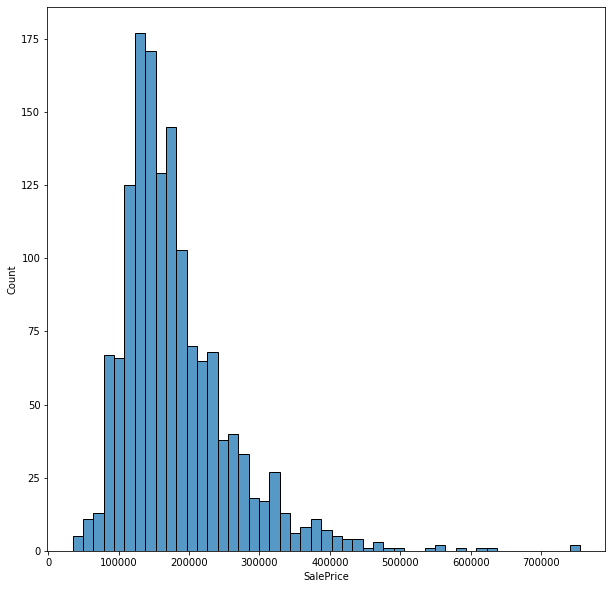

In [27]:
plt.figure(figsize=(10, 10))
sns.histplot(y_train)

#### Here is a helper function to plot a correlation heatmap between the numerical variables, which I'll use later.

In [28]:
def plot_correlation(xdata,ydata,ylabel):
    numeric_cols = [col for col in xdata.columns if (xdata[col].dtype == 'float64') or (xdata[col].dtype == 'int64')]
    data_numeric = xdata[numeric_cols]
    data_numeric[ylabel] = ydata
    sns.heatmap(data_numeric.corr(),cmap="YlGnBu")

#### A lot of categorical features have a clear numerical hierarchy, ie. they can be represented by ascending values with higher representing 'better', so I will convert these features.

In [29]:
alldata['LandSlope'] = alldata['LandSlope'].replace('Gtl',2)
alldata['LandSlope'] = alldata['LandSlope'].replace('Mod',1)
alldata['LandSlope'] = alldata['LandSlope'].replace('Sev',0)

alldata['ExterQual'] = alldata['ExterQual'].replace('Ex',5)
alldata['ExterQual'] = alldata['ExterQual'].replace('Gd',4)
alldata['ExterQual'] = alldata['ExterQual'].replace('TA',3)
alldata['ExterQual'] = alldata['ExterQual'].replace('Fa',2)
alldata['ExterQual'] = alldata['ExterQual'].replace('Po',1)

alldata['ExterCond'] = alldata['ExterCond'].replace('Ex',5)
alldata['ExterCond'] = alldata['ExterCond'].replace('Gd',4)
alldata['ExterCond'] = alldata['ExterCond'].replace('TA',3)
alldata['ExterCond'] = alldata['ExterCond'].replace('Fa',2)
alldata['ExterCond'] = alldata['ExterCond'].replace('Po',1)

alldata['Basement'] = alldata['BsmtQual'].apply(lambda x: 0 if x == 'None' else 1)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('Ex',5)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('Gd',4)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('TA',3)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('Fa',2)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('None',0)

alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('Gd',4)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('Av',3)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('Mn',2)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('No',1)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('None',0)

alldata['BsmtCond'] = alldata['BsmtCond'].replace('Ex',5)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('Gd',4)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('TA',3)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('Fa',2)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('Po',1)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('None',0)

alldata['HeatingQC'] = alldata['HeatingQC'].replace('Ex',5)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('Gd',4)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('TA',3)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('Fa',2)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('Po',1)

alldata['KitchenQual'] = alldata['KitchenQual'].replace('Ex',5)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('Gd',4)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('TA',3)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('Fa',2)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('Po',1)

alldata['Functional'] = alldata['Functional'].replace('Typ',7)
alldata['Functional'] = alldata['Functional'].replace('Min1',6)
alldata['Functional'] = alldata['Functional'].replace('Min2',5)
alldata['Functional'] = alldata['Functional'].replace('Mod',4)
alldata['Functional'] = alldata['Functional'].replace('Maj1',3)
alldata['Functional'] = alldata['Functional'].replace('Maj2',2)
alldata['Functional'] = alldata['Functional'].replace('Sev',1)
alldata['Functional'] = alldata['Functional'].replace('Sal',0)

alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Ex',5)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Gd',4)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('TA',3)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Fa',2)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Po',1)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('None',0)

alldata['GarageFinish'] = alldata['GarageFinish'].replace('Fin',3)
alldata['GarageFinish'] = alldata['GarageFinish'].replace('RFn',2)
alldata['GarageFinish'] = alldata['GarageFinish'].replace('Unf',1)
alldata['GarageFinish'] = alldata['GarageFinish'].replace('None',0)

alldata['GarageQual'] = alldata['GarageQual'].replace('Ex',5)
alldata['GarageQual'] = alldata['GarageQual'].replace('Gd',4)
alldata['GarageQual'] = alldata['GarageQual'].replace('TA',3)
alldata['GarageQual'] = alldata['GarageQual'].replace('Fa',2)
alldata['GarageQual'] = alldata['GarageQual'].replace('Po',1)
alldata['GarageQual'] = alldata['GarageQual'].replace('None',0)

alldata['GarageCond'] = alldata['GarageCond'].replace('Ex',5)
alldata['GarageCond'] = alldata['GarageCond'].replace('Gd',4)
alldata['GarageCond'] = alldata['GarageCond'].replace('TA',3)
alldata['GarageCond'] = alldata['GarageCond'].replace('Fa',2)
alldata['GarageCond'] = alldata['GarageCond'].replace('Po',1)
alldata['GarageCond'] = alldata['GarageCond'].replace('None',0)



#### At this point, I save the data after one-hot encoding the categorical features, in the next steps I'll create some new features.

In [415]:
pd.get_dummies(alldata).to_csv('basic_dummies.csv')

#### Here is the heatmap of all the current features. Most aren't extremely highly correlated, but there are a few exceptions. The target variable seems most correlated with OverallQual and GrLivArea (the above ground square footage)

<ipython-input-413-6914a8e293c0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_numeric[ylabel] = ydata


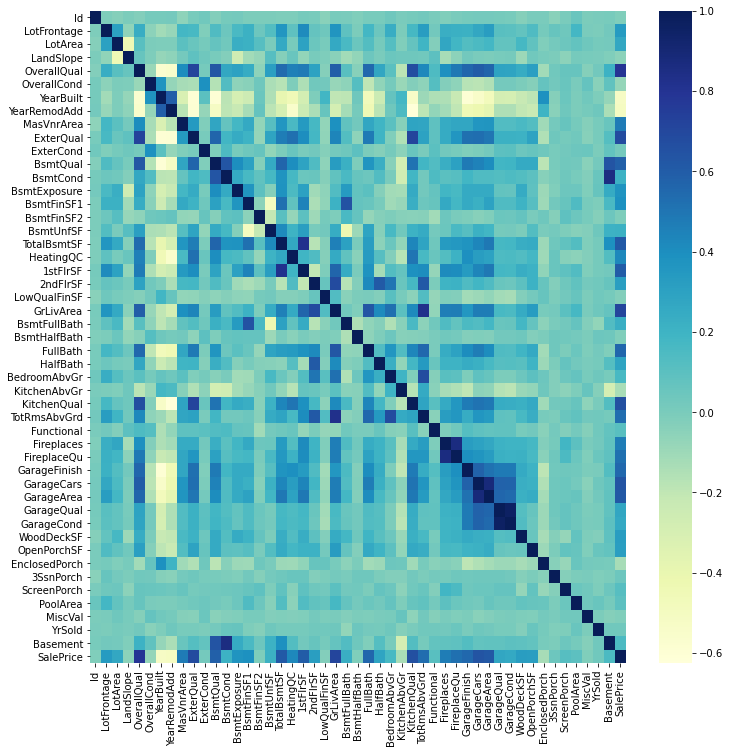

In [416]:
plt.figure(figsize=(12,12))
plot_correlation(alldata.iloc[:1460],y_train,"SalePrice")

#### Here, I create some strip plots of the most important predictor variables.

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

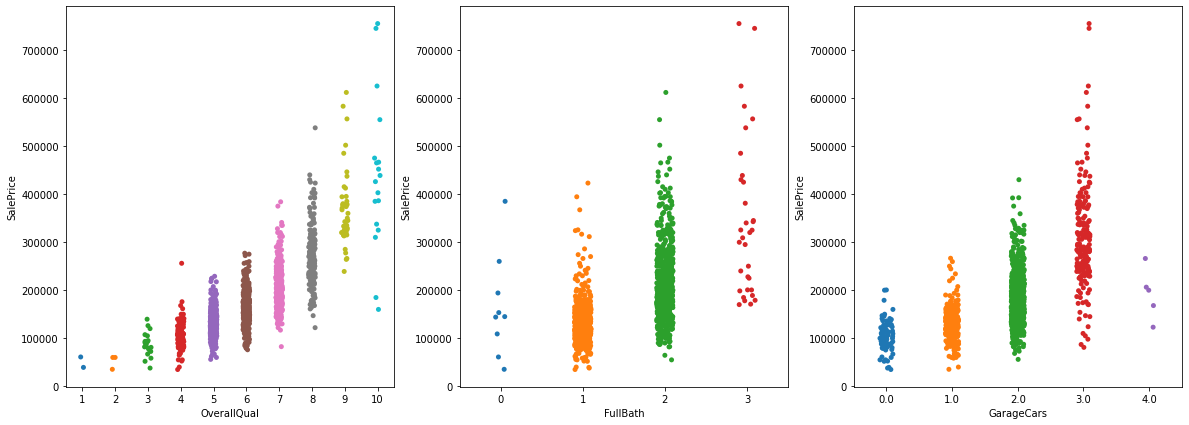

In [417]:
figure, ax = plt.subplots(1,3, figsize = (20,7))
sns.stripplot(x=alldata.loc[:1460,'OverallQual'],y=y_train,ax=ax[0])
sns.stripplot(x=alldata.loc[:1460,'FullBath'],y=y_train,ax=ax[1])
sns.stripplot(x=alldata.loc[:1460,'GarageCars'],y=y_train,ax=ax[2])

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

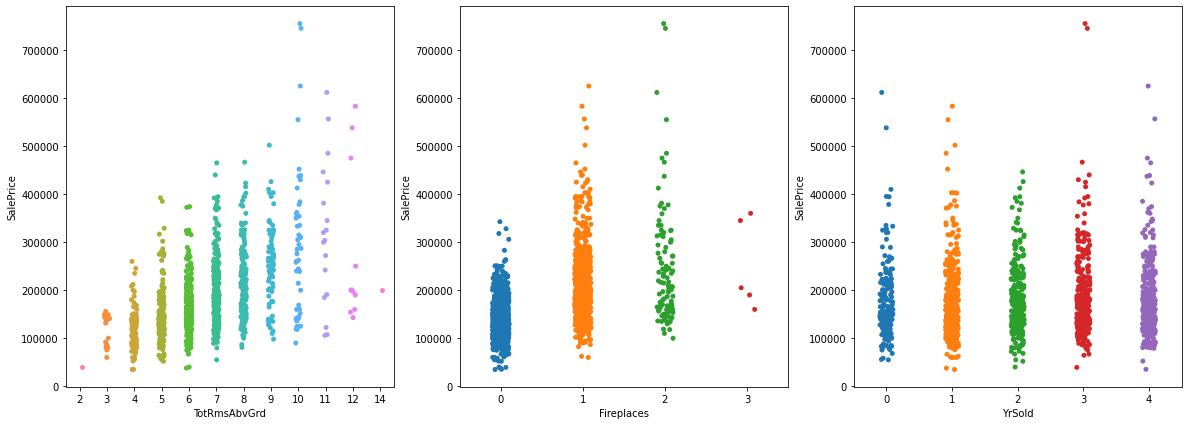

In [418]:
figure, ax = plt.subplots(1,3, figsize = (20,7))
sns.stripplot(x=alldata.loc[:1460,'TotRmsAbvGrd'],y=y_train,ax=ax[0])
sns.stripplot(x=alldata.loc[:1460,'Fireplaces'],y=y_train,ax=ax[1])
sns.stripplot(x=alldata.loc[:1460,'YrSold'],y=y_train,ax=ax[2])

#### Based on the plots, some values provide little to no new information, so I will combine them.

In [419]:
alldata['GarageCars'][alldata['GarageCars'] == 4] = 3
alldata['TotRmsAbvGrd'][alldata['TotRmsAbvGrd'] > 10] = 10
alldata['Fireplaces'][alldata['Fireplaces'] > 2] = 2


<ipython-input-419-98a878290ac8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldata['GarageCars'][alldata['GarageCars'] == 4] = 3
<ipython-input-419-98a878290ac8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldata['TotRmsAbvGrd'][alldata['TotRmsAbvGrd'] > 10] = 10
<ipython-input-419-98a878290ac8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldata['Fireplaces'][alldata['Fireplaces'] > 2] = 2


In [420]:
def normalize(col):
    cmax = col.max()
    cmin = col.min()
    ccopy = col.copy()
    for i in range(len(col)):
        ccopy[i] = col[i] - cmin / (cmax - cmin)
    return ccopy

#### Here I engineer some new features from some of the more relevant features, both linear and nonlinear (multiplicative)

In [421]:
alldata['Qual_Cond'] = alldata['OverallQual'] + alldata['OverallCond']

alldata['TotalBath'] = alldata['FullBath'] + alldata['BsmtFullBath'] + 0.5*(alldata['HalfBath'] + alldata['BsmtHalfBath'])
alldata['Bath_Above'] = alldata['FullBath'] + 0.5*alldata['HalfBath']

alldata['Remodeled'] = alldata['YearBuilt'] - alldata['YearRemodAdd']
alldata['Remodeled'] = alldata['Remodeled'].apply(lambda x: 1 if x > 0 else 0)

alldata['TotalPorch'] = alldata['WoodDeckSF'] + alldata['OpenPorchSF'] + alldata['EnclosedPorch'] + alldata['3SsnPorch'] + alldata['ScreenPorch']

alldata['Age'] = alldata['YearBuilt'].apply(lambda x: np.floor((x+1)/10))
alldata['GarageQual_Cond'] = alldata['GarageQual'] + alldata['GarageCond']

alldata['Qual_SFT'] = alldata['OverallQual'] * alldata['GrLivArea']

alldata['Qual_Rooms'] = alldata['TotRmsAbvGrd'] * alldata['OverallQual']

#### I also drop some of the less valuable features whose relevance will be captured in the new features.

In [422]:
alldata = alldata.drop(['YearBuilt','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','Id'],axis=1)

#### Now I have two sets of data, the 'basic' features, and the data with the newly engineered features.

In [423]:
basic_dummies = pd.read_csv('basic_dummies.csv',index_col=0)
data_dummies = pd.get_dummies(alldata)

In [424]:
basic_dummies.head()

,Id,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,2,7,5,7,7,196.0,4,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,2,6,8,34,34,0.0,3,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,2,7,5,9,8,162.0,4,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,2,7,5,95,40,0.0,3,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,2,8,5,10,10,350.0,4,...,0,0,0,1,0,0,0,0,1,0


In [425]:
data_dummies.head()

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2,7,5,7,196.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,2,6,8,34,0.0,3,3,4,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2,7,5,8,162.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,2,7,5,40,0.0,3,3,3,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2,8,5,10,350.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0


#### I generate some more nonlinear features for the feature engineered data.

In [426]:
for col in data_dummies.columns:
    if 'Neighborhood' in col:
        print(col)
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']
        
    if 'SaleCondition' in col:
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']   
        
    if 'MSZoning' in col:
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']
        
    if 'Foundation' in col:
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']
        
    if col == 'Age':
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']

Neighborhood_Blmngtn
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_IDOTRR
Neighborhood_MeadowV
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_NPkVill
Neighborhood_NWAmes
Neighborhood_NoRidge
Neighborhood_NridgHt
Neighborhood_OldTown
Neighborhood_SWISU
Neighborhood_Sawyer
Neighborhood_SawyerW
Neighborhood_Somerst
Neighborhood_StoneBr
Neighborhood_Timber
Neighborhood_Veenker


In [427]:
data_dummies.to_csv('data_dummies.csv')

In [3]:
data_dummies = pd.read_csv('data_dummies.csv',index_col=0)

In [4]:
data_dummies.shape

(2919, 451)

#### I can use a CatBoost regressor to observe the feature importances for my data:

In [10]:
scaler = MinMaxScaler()
basic_data_normal = pd.DataFrame(scaler.fit_transform(basic_dummies),columns=basic_dummies.columns)

In [11]:
cb = CatBoostRegressor(iterations=2000,max_depth=4,learning_rate=0.01,l2_leaf_reg=1)

In [ ]:
cb.fit(basic_data_normal.iloc[:1460],y_train)

In [16]:
def get_importance(model,data,train_num=1460):
    importance = model.get_feature_importance()
    
    importance_dict = {}
    for i in range(len(importance)):
        importance_dict[data.columns[i]] = importance[i]

    return sorted(importance_dict.items(),key=lambda x: x[1], reverse=True)

In [17]:
importance = cb.get_feature_importance()

importance_list = zip(basic_data_normal.iloc[:1460].columns, importance)
for feature in sorted(importance_list, key = lambda t: t[1], reverse=True):
    print(feature)
    
basic_importance_dict = {}

for i in range(len(importance)):
    basic_importance_dict[basic_data_normal.iloc[:1460].columns[i]] = importance[i]

basic_importance_dict = sorted(basic_importance_dict.items(),key=lambda x: x[1], reverse=True)

('OverallQual', 23.08353085322476)
('GrLivArea', 12.82824797069344)
('TotalBsmtSF', 5.493346141465942)
('ExterQual', 4.804182745679936)
('BsmtFinSF1', 4.718640276224158)
('1stFlrSF', 4.602600619379144)
('GarageCars', 3.8961761452750596)
('BsmtQual', 3.208735542253229)
('KitchenQual', 3.145670764477647)
('LotArea', 3.0801604003010303)
('2ndFlrSF', 2.628640101463038)
('FullBath', 2.016770060059915)
('Fireplaces', 1.8838920725583541)
('GarageArea', 1.5434773230769692)
('TotRmsAbvGrd', 1.525047278547243)
('YearBuilt', 1.4583660483169938)
('GarageFinish', 1.423966874417742)
('YearRemodAdd', 1.338029104925834)
('BsmtExposure', 1.1482362659788028)
('MSSubClass_60', 1.118714766862575)
('OverallCond', 1.1020110369955796)
('FireplaceQu', 1.0257198399918095)
('Neighborhood_Edwards', 0.7635123695202944)
('HalfBath', 0.6971970183235069)
('OpenPorchSF', 0.5830602576812798)
('LandContour_Bnk', 0.5596312162557011)
('LotFrontage', 0.4965092971884982)
('Neighborhood_Crawfor', 0.4780424906484897)
('SaleT

#### This is consistent with the correlation heatmap, OverallQual and GrLivArea are the most important features. Features relating to the basement and the square footage are also notably important, as well as the number of bathrooms and garage car capacity.

In [18]:
basic_data.shape

(2919, 79)

#### Next, I need to establish extreme outliers in the training data. These points will throw off the model and performance will likely be superior if they're removed. I will apply the standard of removing any points with the absolute value of the studentized residual exceeding 3. However, I will also train on the data containing the outliers to show the comparison in performance.

In [19]:
basic_importance = get_importance(cb,basic_dummies)

In [20]:
basic_data_OLS = basic_data_normal[[x[0] for x in basic_importance][:25]]

In [21]:
OLS_model = sm.OLS(y_train,basic_data_OLS.iloc[:1460])
results = OLS_model.fit()

In [22]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              1784.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:00:58   Log-Likelihood:                         -17343.
No. Observations:                1460   AIC:                                  3.474e+04
Df Residuals:                    1435   BIC:                                  3.487e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [23]:
influence = OLSInfluence(results)
sresiduals = influence.resid_studentized_internal
print(sresiduals)

0      -0.290659
1      -0.138186
2      -0.315753
3      -1.525141
4      -1.132288
          ...   
1455   -0.058756
1456   -0.259029
1457    0.352675
1458    0.359516
1459    0.372494
Length: 1460, dtype: float64


#### Here are the studentized residuals exceeding 3

In [24]:
sresiduals[abs(sresiduals) > 3]

178      4.132995
185      4.022509
440      4.641632
473      3.596650
523     -9.774730
688      3.948837
691      8.091751
769      3.745586
774      3.165559
798      3.567767
803      6.344008
898      6.607279
1046     6.000367
1169     6.244045
1182     8.226154
1243     3.043053
1298   -16.118770
1324    -3.541805
dtype: float64

In [25]:
num_outliers = len(sresiduals[abs(sresiduals) > 3])

#### Here, I create a dictionary of datasets with three hyperparameters being varied:

#### 1. Whether the dataset contains the engineered features
#### 2. Whether the dataset contains the outlier points
#### 3. The number of features that the dataset retains (based on the CatBoost ranking)

In [468]:
dataset_dict = {}

dataset_dict['basic_dummies_max'] = basic_dummies
dataset_dict['basic_dummies_max_no_outliers'] = basic_dummies.drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['basic_dummies_200'] = basic_dummies[[x[0] for x in basic_importance][:200]]
dataset_dict['basic_dummies_200_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:200]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['basic_dummies_150'] = basic_dummies[[x[0] for x in basic_importance][:150]]
dataset_dict['basic_dummies_150_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:150]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['basic_dummies_100'] = basic_dummies[[x[0] for x in basic_importance][:100]]
dataset_dict['basic_dummies_100_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:100]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)

dataset_dict['data_dummies_max'] = data_dummies
dataset_dict['data_dummies_max_no_outliers'] = data_dummies.drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['data_dummies_200'] = data_dummies[[x[0] for x in importance][:200]]
dataset_dict['data_dummies_200_no_outliers'] = data_dummies[[x[0] for x in importance][:200]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['data_dummies_150'] = data_dummies[[x[0] for x in importance][:150]]
dataset_dict['data_dummies_150_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:150]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['data_dummies_100'] = data_dummies[[x[0] for x in importance][:100]]
dataset_dict['data_dummies_100_no_outliers'] = data_dummies[[x[0] for x in importance][:100]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)

In [469]:
for key,data in dataset_dict.items():
    print(f"Name: {key}, Shape: {data.shape}")

Name: basic_dummies_max, Shape: (2919, 277)
Name: basic_dummies_max_no_outliers, Shape: (2901, 277)
Name: basic_dummies_200, Shape: (2919, 200)
Name: basic_dummies_200_no_outliers, Shape: (2901, 200)
Name: basic_dummies_150, Shape: (2919, 150)
Name: basic_dummies_150_no_outliers, Shape: (2901, 150)
Name: basic_dummies_100, Shape: (2919, 100)
Name: basic_dummies_100_no_outliers, Shape: (2901, 100)
Name: data_dummies_max, Shape: (2919, 451)
Name: data_dummies_max_no_outliers, Shape: (2901, 451)
Name: data_dummies_200, Shape: (2919, 200)
Name: data_dummies_200_no_outliers, Shape: (2901, 200)
Name: data_dummies_150, Shape: (2919, 150)
Name: data_dummies_150_no_outliers, Shape: (2901, 150)
Name: data_dummies_100, Shape: (2919, 100)
Name: data_dummies_100_no_outliers, Shape: (2901, 100)


In [481]:
num_outliers

18

#### Here, I define a function to split each dataset in the dictionary into training and validation:

In [496]:
def train_validation_split(name,xdata,p=0.3):
    outliers=0
    ydata = y_train
    if 'outliers' in name:
        print('hi')
        xdata = xdata.reset_index().iloc[:,1:]
        ydata = y_train.drop(sresiduals[abs(sresiduals) > 3].index,axis=0).reset_index().iloc[:,1:]
        outliers = num_outliers
    return train_test_split(xdata.iloc[:(1460-outliers)],ydata,test_size=p,random_state=42)

#### I construct a relatively simple CatBoost model as a preliminary means of observing the performance of each dataset, and fit the model to each dataset.

In [493]:
preliminary_model = CatBoostRegressor(iterations=5000,max_depth=4,learning_rate=0.01,l2_leaf_reg=3,verbose=0,od_wait=200)

In [494]:
for key,data in dataset_dict.items():
    Xt,Xv,yt,yv = train_validation_split(key,data)
    preliminary_model.fit(Xt,yt,eval_set=(Xv,yv))
    print(f"Name: {key}, Result: {np.sqrt(mean_squared_error(yv,preliminary_model.predict(Xv)))}")

Name: basic_dummies_max, Result: 22381.49670380449
hi
Name: basic_dummies_max_no_outliers, Result: 18089.674213071667
Name: basic_dummies_200, Result: 22978.15437440461
hi
Name: basic_dummies_200_no_outliers, Result: 16847.68249003425
Name: basic_dummies_150, Result: 21877.968100814087
hi
Name: basic_dummies_150_no_outliers, Result: 17419.042646350037
Name: basic_dummies_100, Result: 27685.27476513819
hi
Name: basic_dummies_100_no_outliers, Result: 19668.454866820444
Name: data_dummies_max, Result: 26743.0965591727
hi
Name: data_dummies_max_no_outliers, Result: 19436.03328368384
Name: data_dummies_200, Result: 22862.584693612316
hi
Name: data_dummies_200_no_outliers, Result: 19427.51935354612
Name: data_dummies_150, Result: 21927.81064878785
hi
Name: data_dummies_150_no_outliers, Result: 19662.676970742847
Name: data_dummies_100, Result: 24454.382588485216
hi
Name: data_dummies_100_no_outliers, Result: 18727.24894816585


#### It can be instantly concluded that the model performs far better on the data with outliers removed in all cases, so I will remove all the datasets containing the outliers from the dict.

In [495]:
for x in ['basic_dummies_max','basic_dummies_200','basic_dummies_150','basic_dummies_100','data_dummies_max',
         'data_dummies_200','data_dummies_150','data_dummies_100']:
    del dataset_dict[x]

#### I define a larger model to train again on the remaining datasets

In [497]:
second_model = CatBoostRegressor(iterations=10000,max_depth=4,learning_rate=0.005,l2_leaf_reg=3,verbose=0,od_wait=200,random_state=42)

In [498]:
for key,data in dataset_dict.items():
    Xt,Xv,yt,yv = train_validation_split(key,data)
    second_model.fit(Xt,yt,eval_set=(Xv,yv))
    print(f"Name: {key}, Result: {np.sqrt(mean_squared_error(yv,second_model.predict(Xv)))}")

hi
Name: basic_dummies_max_no_outliers, Result: 16760.125864429698
hi
Name: basic_dummies_200_no_outliers, Result: 16642.940189624096
hi
Name: basic_dummies_150_no_outliers, Result: 16635.8735336892
hi
Name: basic_dummies_100_no_outliers, Result: 16577.979421729477
hi
Name: data_dummies_max_no_outliers, Result: 16981.93995986067
hi
Name: data_dummies_200_no_outliers, Result: 16821.103710667852
hi
Name: data_dummies_150_no_outliers, Result: 16635.8735336892
hi
Name: data_dummies_100_no_outliers, Result: 16398.431388519366


#### The difference in performance isn't significant between the models, but I will choose the best-performing one, which is the dataset with engineered features limited to the best 100 features.

In [500]:
selected_data = dataset_dict['data_dummies_100_no_outliers']

#### I will now try a few different model architectures on the selected dataset, starting with RandomForest.

#### I create a parameter grid and use GridCV to test the model with all different parameter combinations.

In [508]:
rf = RandomForestRegressor(random_state=42)

In [507]:
rf_params = {
    'n_estimators': [1000,2000,5000],
    'max_depth': [3,5,7],
}

In [526]:
rf_params2 = {
    'n_estimators': [5000],
    'max_depth': [16],
}

In [527]:
rf_cv = GridSearchCV(rf,param_grid=rf_params2,cv=4,verbose=2,refit=True,scoring='neg_root_mean_squared_error')

In [528]:
Xt = selected_data[:1460-num_outliers].reset_index().iloc[:,1:]
yt = y_train.drop(sresiduals[abs(sresiduals) > 3].index,axis=0).reset_index().iloc[:,1:]

In [570]:
Xtest = selected_data[1460-num_outliers:]

In [529]:
rf_cv.fit(Xt,yt)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [16], 'n_estimators': [5000]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [530]:
rf_cv.cv_results_['mean_test_score']

array([-22282.81378228])

#### The random forest doesn't perform nearly as well as the initial CatBoost regressor.

In [525]:
rf_cv.best_params_

{'max_depth': 16, 'n_estimators': 2000}

#### Next, I will try XGBoost

In [537]:
xgb_params = {
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.025,0.05],
    'min_child_weight': [1,2]
}

In [540]:
xgb = XGBRegressor(n_estimators=10000,random_state=42)

In [541]:
xgb_cv = GridSearchCV(xgb,param_grid=xgb_params,cv=4,verbose=2,refit=True,scoring='neg_root_mean_squared_error')

In [542]:
xgb_cv.fit(Xt,yt)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  14.5s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  23.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  21.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  23.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.9s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1; total time=  31.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1; total time=  34.9s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1; total time=  31.9s
[CV] END learning_rate=0.01, max_depth=5, min_ch

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_delta_step=None,
                                    max_depth=5, min_child_weight=2,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=10000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=100, reg_lambda=1,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             param_grid={'learning_rate': [0.01, 0.025, 0.05],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 2]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [543]:
xgb_cv.cv_results_['mean_test_score']

array([-19244.30269429, -19106.19710736, -20539.42491193, -20318.83175196,
       -21418.25055293, -20916.68032895, -19247.91581876, -19338.8315725 ,
       -20493.25745995, -20268.90223058, -21322.22356029, -20870.32400986,
       -19412.48419019, -19080.27711073, -20393.29712386, -20350.12064422,
       -21471.87134242, -21088.46912331])

#### I use the best parameters found from the grid search, and apply the model with early stopping:

In [544]:
xgb_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2}

In [545]:
xgb_selected = XGBRegressor(n_estimators=20000,learning_rate=0.05,max_depth=3,min_child_weight=2,random_state=42)

In [550]:
X,Xv,y,yv = train_test_split(Xt,yt,test_size=0.25,random_state=42)

In [551]:
y.shape

(1081, 1)

In [ ]:
xgb_selected.fit(X, y, eval_set=[(X, y), (Xv, yv)], early_stopping_rounds=200) 

#### Validation score is around 17,000, which is a good score but not as low as CatBoost

#### Now I perform grid search using the CatBoost regressor:

In [554]:
cb = CatBoostRegressor(verbose=0,random_state=42)

In [555]:
cb_params = {
    'iterations': [5000,10000],
    'max_depth': [3,4,5],
    'learning_rate': [0.005,0.01,0.025],
    'l2_leaf_reg': [1,3]
}

In [558]:
cb_cv = GridSearchCV(cb,param_grid=cb_params,cv=4,verbose=2,refit=True,scoring='neg_root_mean_squared_error')

In [ ]:
cb_cv.fit(Xt,yt)

In [560]:
cb_cv.cv_results_['mean_test_score']

array([-18270.77378971, -18116.69007404, -18138.91362021, -18066.70719205,
       -18030.80491818, -18171.63735918, -18319.64978081, -18132.19054064,
       -18311.98920678, -18472.07020713, -18252.50041197, -18207.01950656,
       -18166.33729826, -18156.45127519, -18083.78402668, -18262.05653048,
       -18291.44977362, -18296.54223249, -18070.62939298, -18053.11755852,
       -18109.81504983, -18168.95066476, -18115.69405783, -18231.94287808,
       -18466.88447944, -18194.39180761, -18341.34123634, -18105.74976306,
       -18131.09789362, -18135.41851174, -18213.93886082, -18241.52416135,
       -18155.16184412, -18392.83451298, -18395.14600339, -18337.85666651])

#### I identify the best parameters and train a model with them using early stopping. This provides the best RMSE so far.

In [561]:
cb_cv.best_params_

{'iterations': 5000, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'max_depth': 4}

In [563]:
cb_selected = CatBoostRegressor(iterations=20000,learning_rate=0.01,max_depth=4,l2_leaf_reg=1,random_state=42,od_wait=250)

In [ ]:
cb_selected.fit(X, y, eval_set=(Xv, yv))

#### Test set evaluation is on Kaggle, and uses RMSLE as the metric. CatBoostRegressor doesn't have native support for RMSLE as an evaluation metric, so I write a class that is compatible with CatBoost:

In [562]:
class CatBoostEvalMetricRMSLE(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        # the larger metric value the better
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        preds = np.array(approxes[0])
        target = np.array(target)
        score = np.sqrt(mean_squared_log_error(target,preds))
        return score, 0

In [566]:
cb_selected_RMSLE = CatBoostRegressor(iterations=20000,learning_rate=0.01,max_depth=4,l2_leaf_reg=1,random_state=42,
                                     eval_metric=CatBoostEvalMetricRMSLE(),od_wait=250)

In [567]:
cb_selected_RMSLE.fit(X, y, eval_set=(Xv, yv))

0:	learn: 0.3918587	test: 0.3926090	best: 0.3926090 (0)	total: 9.15ms	remaining: 3m 2s
1:	learn: 0.3893025	test: 0.3903152	best: 0.3903152 (1)	total: 13.8ms	remaining: 2m 18s
2:	learn: 0.3866836	test: 0.3878422	best: 0.3878422 (2)	total: 17.7ms	remaining: 1m 58s
3:	learn: 0.3842159	test: 0.3855787	best: 0.3855787 (3)	total: 21.5ms	remaining: 1m 47s
4:	learn: 0.3817623	test: 0.3833608	best: 0.3833608 (4)	total: 24.5ms	remaining: 1m 38s
5:	learn: 0.3793157	test: 0.3812103	best: 0.3812103 (5)	total: 29.9ms	remaining: 1m 39s
6:	learn: 0.3769814	test: 0.3790916	best: 0.3790916 (6)	total: 32.9ms	remaining: 1m 33s
7:	learn: 0.3746030	test: 0.3770039	best: 0.3770039 (7)	total: 35.8ms	remaining: 1m 29s
8:	learn: 0.3721744	test: 0.3749000	best: 0.3749000 (8)	total: 38.7ms	remaining: 1m 25s
9:	learn: 0.3698203	test: 0.3728042	best: 0.3728042 (9)	total: 41.9ms	remaining: 1m 23s
10:	learn: 0.3676999	test: 0.3708497	best: 0.3708497 (10)	total: 46.6ms	remaining: 1m 24s
11:	learn: 0.3656064	test: 0.36

98:	learn: 0.2400889	test: 0.2508565	best: 0.2508565 (98)	total: 331ms	remaining: 1m 6s
99:	learn: 0.2393297	test: 0.2500578	best: 0.2500578 (99)	total: 334ms	remaining: 1m 6s
100:	learn: 0.2383487	test: 0.2490712	best: 0.2490712 (100)	total: 337ms	remaining: 1m 6s
101:	learn: 0.2374279	test: 0.2481420	best: 0.2481420 (101)	total: 340ms	remaining: 1m 6s
102:	learn: 0.2365065	test: 0.2472501	best: 0.2472501 (102)	total: 343ms	remaining: 1m 6s
103:	learn: 0.2358338	test: 0.2466219	best: 0.2466219 (103)	total: 345ms	remaining: 1m 6s
104:	learn: 0.2349332	test: 0.2457343	best: 0.2457343 (104)	total: 349ms	remaining: 1m 6s
105:	learn: 0.2340842	test: 0.2449431	best: 0.2449431 (105)	total: 351ms	remaining: 1m 5s
106:	learn: 0.2331726	test: 0.2439623	best: 0.2439623 (106)	total: 354ms	remaining: 1m 5s
107:	learn: 0.2322085	test: 0.2430241	best: 0.2430241 (107)	total: 357ms	remaining: 1m 5s
108:	learn: 0.2313135	test: 0.2421188	best: 0.2421188 (108)	total: 360ms	remaining: 1m 5s
109:	learn: 0.

199:	learn: 0.1777453	test: 0.1896167	best: 0.1896167 (199)	total: 655ms	remaining: 1m 4s
200:	learn: 0.1773217	test: 0.1892198	best: 0.1892198 (200)	total: 658ms	remaining: 1m 4s
201:	learn: 0.1769104	test: 0.1888187	best: 0.1888187 (201)	total: 661ms	remaining: 1m 4s
202:	learn: 0.1765173	test: 0.1884428	best: 0.1884428 (202)	total: 664ms	remaining: 1m 4s
203:	learn: 0.1760666	test: 0.1880483	best: 0.1880483 (203)	total: 667ms	remaining: 1m 4s
204:	learn: 0.1756502	test: 0.1876290	best: 0.1876290 (204)	total: 670ms	remaining: 1m 4s
205:	learn: 0.1753126	test: 0.1872808	best: 0.1872808 (205)	total: 674ms	remaining: 1m 4s
206:	learn: 0.1749330	test: 0.1869175	best: 0.1869175 (206)	total: 677ms	remaining: 1m 4s
207:	learn: 0.1744710	test: 0.1864912	best: 0.1864912 (207)	total: 680ms	remaining: 1m 4s
208:	learn: 0.1739840	test: 0.1859687	best: 0.1859687 (208)	total: 682ms	remaining: 1m 4s
209:	learn: 0.1735644	test: 0.1855250	best: 0.1855250 (209)	total: 686ms	remaining: 1m 4s
210:	learn

304:	learn: 0.1471166	test: 0.1599157	best: 0.1599157 (304)	total: 980ms	remaining: 1m 3s
305:	learn: 0.1468586	test: 0.1596993	best: 0.1596993 (305)	total: 983ms	remaining: 1m 3s
306:	learn: 0.1466321	test: 0.1594816	best: 0.1594816 (306)	total: 986ms	remaining: 1m 3s
307:	learn: 0.1464137	test: 0.1592181	best: 0.1592181 (307)	total: 990ms	remaining: 1m 3s
308:	learn: 0.1462407	test: 0.1590612	best: 0.1590612 (308)	total: 993ms	remaining: 1m 3s
309:	learn: 0.1461145	test: 0.1589409	best: 0.1589409 (309)	total: 998ms	remaining: 1m 3s
310:	learn: 0.1459498	test: 0.1588293	best: 0.1588293 (310)	total: 1s	remaining: 1m 3s
311:	learn: 0.1456920	test: 0.1586249	best: 0.1586249 (311)	total: 1s	remaining: 1m 3s
312:	learn: 0.1454188	test: 0.1583392	best: 0.1583392 (312)	total: 1.01s	remaining: 1m 3s
313:	learn: 0.1451436	test: 0.1580996	best: 0.1580996 (313)	total: 1.01s	remaining: 1m 3s
314:	learn: 0.1449457	test: 0.1579752	best: 0.1579752 (314)	total: 1.02s	remaining: 1m 3s
315:	learn: 0.14

446:	learn: 0.1246215	test: 0.1396199	best: 0.1396199 (446)	total: 1.46s	remaining: 1m 4s
447:	learn: 0.1245001	test: 0.1394930	best: 0.1394930 (447)	total: 1.47s	remaining: 1m 4s
448:	learn: 0.1243605	test: 0.1393389	best: 0.1393389 (448)	total: 1.47s	remaining: 1m 4s
449:	learn: 0.1242592	test: 0.1392574	best: 0.1392574 (449)	total: 1.47s	remaining: 1m 4s
450:	learn: 0.1241173	test: 0.1391229	best: 0.1391229 (450)	total: 1.48s	remaining: 1m 4s
451:	learn: 0.1240018	test: 0.1390337	best: 0.1390337 (451)	total: 1.48s	remaining: 1m 3s
452:	learn: 0.1239592	test: 0.1390194	best: 0.1390194 (452)	total: 1.48s	remaining: 1m 3s
453:	learn: 0.1238538	test: 0.1389713	best: 0.1389713 (453)	total: 1.49s	remaining: 1m 3s
454:	learn: 0.1237694	test: 0.1388591	best: 0.1388591 (454)	total: 1.49s	remaining: 1m 3s
455:	learn: 0.1236634	test: 0.1387876	best: 0.1387876 (455)	total: 1.49s	remaining: 1m 3s
456:	learn: 0.1235953	test: 0.1387260	best: 0.1387260 (456)	total: 1.5s	remaining: 1m 3s
457:	learn:

547:	learn: 0.1156719	test: 0.1325237	best: 0.1325237 (547)	total: 1.79s	remaining: 1m 3s
548:	learn: 0.1156005	test: 0.1324422	best: 0.1324422 (548)	total: 1.79s	remaining: 1m 3s
549:	learn: 0.1155237	test: 0.1323784	best: 0.1323784 (549)	total: 1.79s	remaining: 1m 3s
550:	learn: 0.1154079	test: 0.1322626	best: 0.1322626 (550)	total: 1.8s	remaining: 1m 3s
551:	learn: 0.1153665	test: 0.1322376	best: 0.1322376 (551)	total: 1.8s	remaining: 1m 3s
552:	learn: 0.1152882	test: 0.1321669	best: 0.1321669 (552)	total: 1.81s	remaining: 1m 3s
553:	learn: 0.1152138	test: 0.1321224	best: 0.1321224 (553)	total: 1.81s	remaining: 1m 3s
554:	learn: 0.1151710	test: 0.1321039	best: 0.1321039 (554)	total: 1.81s	remaining: 1m 3s
555:	learn: 0.1151126	test: 0.1320427	best: 0.1320427 (555)	total: 1.82s	remaining: 1m 3s
556:	learn: 0.1150417	test: 0.1319737	best: 0.1319737 (556)	total: 1.82s	remaining: 1m 3s
557:	learn: 0.1149235	test: 0.1318907	best: 0.1318907 (557)	total: 1.82s	remaining: 1m 3s
558:	learn: 

651:	learn: 0.1093700	test: 0.1282393	best: 0.1282393 (651)	total: 2.11s	remaining: 1m 2s
652:	learn: 0.1093495	test: 0.1282339	best: 0.1282339 (652)	total: 2.12s	remaining: 1m 2s
653:	learn: 0.1093216	test: 0.1282122	best: 0.1282122 (653)	total: 2.12s	remaining: 1m 2s
654:	learn: 0.1093044	test: 0.1282117	best: 0.1282117 (654)	total: 2.12s	remaining: 1m 2s
655:	learn: 0.1091981	test: 0.1281199	best: 0.1281199 (655)	total: 2.12s	remaining: 1m 2s
656:	learn: 0.1091242	test: 0.1280223	best: 0.1280223 (656)	total: 2.13s	remaining: 1m 2s
657:	learn: 0.1090480	test: 0.1278830	best: 0.1278830 (657)	total: 2.13s	remaining: 1m 2s
658:	learn: 0.1089999	test: 0.1278625	best: 0.1278625 (658)	total: 2.13s	remaining: 1m 2s
659:	learn: 0.1089265	test: 0.1278092	best: 0.1278092 (659)	total: 2.14s	remaining: 1m 2s
660:	learn: 0.1088749	test: 0.1277551	best: 0.1277551 (660)	total: 2.14s	remaining: 1m 2s
661:	learn: 0.1088280	test: 0.1277299	best: 0.1277299 (661)	total: 2.14s	remaining: 1m 2s
662:	learn

762:	learn: 0.1038573	test: 0.1243465	best: 0.1243465 (762)	total: 2.43s	remaining: 1m 1s
763:	learn: 0.1038273	test: 0.1243278	best: 0.1243278 (763)	total: 2.44s	remaining: 1m 1s
764:	learn: 0.1037627	test: 0.1242726	best: 0.1242726 (764)	total: 2.44s	remaining: 1m 1s
765:	learn: 0.1037036	test: 0.1242472	best: 0.1242472 (765)	total: 2.44s	remaining: 1m 1s
766:	learn: 0.1036512	test: 0.1241741	best: 0.1241741 (766)	total: 2.45s	remaining: 1m 1s
767:	learn: 0.1036229	test: 0.1241396	best: 0.1241396 (767)	total: 2.45s	remaining: 1m 1s
768:	learn: 0.1035744	test: 0.1240991	best: 0.1240991 (768)	total: 2.45s	remaining: 1m 1s
769:	learn: 0.1035590	test: 0.1240893	best: 0.1240893 (769)	total: 2.46s	remaining: 1m 1s
770:	learn: 0.1035204	test: 0.1240662	best: 0.1240662 (770)	total: 2.46s	remaining: 1m 1s
771:	learn: 0.1034685	test: 0.1240360	best: 0.1240360 (771)	total: 2.46s	remaining: 1m 1s
772:	learn: 0.1033960	test: 0.1239989	best: 0.1239989 (772)	total: 2.46s	remaining: 1m 1s
773:	learn

860:	learn: 0.1000272	test: 0.1217812	best: 0.1217812 (860)	total: 2.75s	remaining: 1m 1s
861:	learn: 0.1000012	test: 0.1217840	best: 0.1217812 (860)	total: 2.76s	remaining: 1m 1s
862:	learn: 0.0999693	test: 0.1217629	best: 0.1217629 (862)	total: 2.76s	remaining: 1m 1s
863:	learn: 0.0999524	test: 0.1217596	best: 0.1217596 (863)	total: 2.76s	remaining: 1m 1s
864:	learn: 0.0999330	test: 0.1217579	best: 0.1217579 (864)	total: 2.77s	remaining: 1m 1s
865:	learn: 0.0998707	test: 0.1217178	best: 0.1217178 (865)	total: 2.77s	remaining: 1m 1s
866:	learn: 0.0998155	test: 0.1216933	best: 0.1216933 (866)	total: 2.77s	remaining: 1m 1s
867:	learn: 0.0997943	test: 0.1216799	best: 0.1216799 (867)	total: 2.78s	remaining: 1m 1s
868:	learn: 0.0997600	test: 0.1216482	best: 0.1216482 (868)	total: 2.78s	remaining: 1m 1s
869:	learn: 0.0997528	test: 0.1216481	best: 0.1216481 (869)	total: 2.78s	remaining: 1m 1s
870:	learn: 0.0997233	test: 0.1216234	best: 0.1216234 (870)	total: 2.79s	remaining: 1m 1s
871:	learn

964:	learn: 0.0967631	test: 0.1198645	best: 0.1198645 (964)	total: 3.08s	remaining: 1m
965:	learn: 0.0967025	test: 0.1198246	best: 0.1198246 (965)	total: 3.09s	remaining: 1m
966:	learn: 0.0966960	test: 0.1198255	best: 0.1198246 (965)	total: 3.09s	remaining: 1m
967:	learn: 0.0966548	test: 0.1197978	best: 0.1197978 (967)	total: 3.09s	remaining: 1m
968:	learn: 0.0966355	test: 0.1197805	best: 0.1197805 (968)	total: 3.1s	remaining: 1m
969:	learn: 0.0966231	test: 0.1197727	best: 0.1197727 (969)	total: 3.1s	remaining: 1m
970:	learn: 0.0965637	test: 0.1197415	best: 0.1197415 (970)	total: 3.1s	remaining: 1m
971:	learn: 0.0965496	test: 0.1197374	best: 0.1197374 (971)	total: 3.1s	remaining: 1m
972:	learn: 0.0964850	test: 0.1197042	best: 0.1197042 (972)	total: 3.11s	remaining: 1m
973:	learn: 0.0964416	test: 0.1196834	best: 0.1196834 (973)	total: 3.11s	remaining: 1m
974:	learn: 0.0964218	test: 0.1196799	best: 0.1196799 (974)	total: 3.11s	remaining: 1m
975:	learn: 0.0963930	test: 0.1196481	best: 0.1

1069:	learn: 0.0938703	test: 0.1181677	best: 0.1181677 (1069)	total: 3.4s	remaining: 1m
1070:	learn: 0.0938501	test: 0.1181407	best: 0.1181407 (1070)	total: 3.4s	remaining: 1m
1071:	learn: 0.0938380	test: 0.1181379	best: 0.1181379 (1071)	total: 3.41s	remaining: 1m
1072:	learn: 0.0938205	test: 0.1180899	best: 0.1180899 (1072)	total: 3.41s	remaining: 1m
1073:	learn: 0.0937734	test: 0.1180576	best: 0.1180576 (1073)	total: 3.41s	remaining: 1m
1074:	learn: 0.0937153	test: 0.1180347	best: 0.1180347 (1074)	total: 3.42s	remaining: 1m
1075:	learn: 0.0936991	test: 0.1180171	best: 0.1180171 (1075)	total: 3.42s	remaining: 1m
1076:	learn: 0.0936916	test: 0.1180218	best: 0.1180171 (1075)	total: 3.42s	remaining: 1m
1077:	learn: 0.0936574	test: 0.1180093	best: 0.1180093 (1077)	total: 3.43s	remaining: 1m
1078:	learn: 0.0936376	test: 0.1179916	best: 0.1179916 (1078)	total: 3.43s	remaining: 1m
1079:	learn: 0.0936220	test: 0.1179988	best: 0.1179916 (1078)	total: 3.43s	remaining: 1m
1080:	learn: 0.0935997	

1173:	learn: 0.0911363	test: 0.1166850	best: 0.1166850 (1173)	total: 3.73s	remaining: 59.7s
1174:	learn: 0.0910958	test: 0.1166710	best: 0.1166710 (1174)	total: 3.73s	remaining: 59.7s
1175:	learn: 0.0910783	test: 0.1166577	best: 0.1166577 (1175)	total: 3.73s	remaining: 59.7s
1176:	learn: 0.0910647	test: 0.1166389	best: 0.1166389 (1176)	total: 3.73s	remaining: 59.7s
1177:	learn: 0.0910336	test: 0.1166063	best: 0.1166063 (1177)	total: 3.74s	remaining: 59.7s
1178:	learn: 0.0910070	test: 0.1165814	best: 0.1165814 (1178)	total: 3.74s	remaining: 59.7s
1179:	learn: 0.0909874	test: 0.1165627	best: 0.1165627 (1179)	total: 3.74s	remaining: 59.7s
1180:	learn: 0.0909743	test: 0.1165444	best: 0.1165444 (1180)	total: 3.75s	remaining: 59.7s
1181:	learn: 0.0909409	test: 0.1165417	best: 0.1165417 (1181)	total: 3.75s	remaining: 59.7s
1182:	learn: 0.0909296	test: 0.1165464	best: 0.1165417 (1181)	total: 3.75s	remaining: 59.7s
1183:	learn: 0.0909164	test: 0.1165446	best: 0.1165417 (1181)	total: 3.76s	remai

1283:	learn: 0.0886281	test: 0.1156420	best: 0.1156420 (1283)	total: 4.05s	remaining: 59s
1284:	learn: 0.0886139	test: 0.1156409	best: 0.1156409 (1284)	total: 4.05s	remaining: 59s
1285:	learn: 0.0885927	test: 0.1156403	best: 0.1156403 (1285)	total: 4.06s	remaining: 59s
1286:	learn: 0.0885741	test: 0.1156377	best: 0.1156377 (1286)	total: 4.06s	remaining: 59s
1287:	learn: 0.0885544	test: 0.1156309	best: 0.1156309 (1287)	total: 4.06s	remaining: 59s
1288:	learn: 0.0885374	test: 0.1156175	best: 0.1156175 (1288)	total: 4.07s	remaining: 59s
1289:	learn: 0.0885154	test: 0.1156079	best: 0.1156079 (1289)	total: 4.07s	remaining: 59s
1290:	learn: 0.0884938	test: 0.1156041	best: 0.1156041 (1290)	total: 4.07s	remaining: 59s
1291:	learn: 0.0884837	test: 0.1156037	best: 0.1156037 (1291)	total: 4.07s	remaining: 59s
1292:	learn: 0.0884585	test: 0.1155922	best: 0.1155922 (1292)	total: 4.08s	remaining: 59s
1293:	learn: 0.0884353	test: 0.1155720	best: 0.1155720 (1293)	total: 4.08s	remaining: 59s
1294:	lear

1395:	learn: 0.0862741	test: 0.1148394	best: 0.1148394 (1395)	total: 4.37s	remaining: 58.3s
1396:	learn: 0.0862621	test: 0.1148269	best: 0.1148269 (1396)	total: 4.38s	remaining: 58.3s
1397:	learn: 0.0862554	test: 0.1148270	best: 0.1148269 (1396)	total: 4.38s	remaining: 58.3s
1398:	learn: 0.0862314	test: 0.1148120	best: 0.1148120 (1398)	total: 4.38s	remaining: 58.3s
1399:	learn: 0.0861895	test: 0.1147838	best: 0.1147838 (1399)	total: 4.38s	remaining: 58.3s
1400:	learn: 0.0861747	test: 0.1147732	best: 0.1147732 (1400)	total: 4.39s	remaining: 58.3s
1401:	learn: 0.0861714	test: 0.1147733	best: 0.1147732 (1400)	total: 4.39s	remaining: 58.3s
1402:	learn: 0.0861663	test: 0.1147714	best: 0.1147714 (1402)	total: 4.39s	remaining: 58.3s
1403:	learn: 0.0861487	test: 0.1147601	best: 0.1147601 (1403)	total: 4.4s	remaining: 58.3s
1404:	learn: 0.0861296	test: 0.1147280	best: 0.1147280 (1404)	total: 4.4s	remaining: 58.3s
1405:	learn: 0.0861165	test: 0.1147400	best: 0.1147280 (1404)	total: 4.41s	remaini

1507:	learn: 0.0845188	test: 0.1143751	best: 0.1143751 (1507)	total: 4.7s	remaining: 57.6s
1508:	learn: 0.0845084	test: 0.1143841	best: 0.1143751 (1507)	total: 4.7s	remaining: 57.6s
1509:	learn: 0.0844851	test: 0.1143778	best: 0.1143751 (1507)	total: 4.7s	remaining: 57.6s
1510:	learn: 0.0844803	test: 0.1143779	best: 0.1143751 (1507)	total: 4.71s	remaining: 57.6s
1511:	learn: 0.0844420	test: 0.1143683	best: 0.1143683 (1511)	total: 4.71s	remaining: 57.6s
1512:	learn: 0.0844089	test: 0.1143768	best: 0.1143683 (1511)	total: 4.71s	remaining: 57.6s
1513:	learn: 0.0843983	test: 0.1143814	best: 0.1143683 (1511)	total: 4.71s	remaining: 57.6s
1514:	learn: 0.0843846	test: 0.1143844	best: 0.1143683 (1511)	total: 4.72s	remaining: 57.6s
1515:	learn: 0.0843673	test: 0.1143757	best: 0.1143683 (1511)	total: 4.72s	remaining: 57.6s
1516:	learn: 0.0843603	test: 0.1143753	best: 0.1143683 (1511)	total: 4.72s	remaining: 57.6s
1517:	learn: 0.0843175	test: 0.1143707	best: 0.1143683 (1511)	total: 4.73s	remainin

1621:	learn: 0.0826383	test: 0.1141025	best: 0.1141025 (1621)	total: 5.02s	remaining: 56.9s
1622:	learn: 0.0826239	test: 0.1140997	best: 0.1140997 (1622)	total: 5.02s	remaining: 56.9s
1623:	learn: 0.0826175	test: 0.1140997	best: 0.1140997 (1622)	total: 5.02s	remaining: 56.9s
1624:	learn: 0.0826137	test: 0.1140984	best: 0.1140984 (1624)	total: 5.03s	remaining: 56.9s
1625:	learn: 0.0826043	test: 0.1140848	best: 0.1140848 (1625)	total: 5.03s	remaining: 56.8s
1626:	learn: 0.0825784	test: 0.1140786	best: 0.1140786 (1626)	total: 5.03s	remaining: 56.8s
1627:	learn: 0.0825536	test: 0.1140879	best: 0.1140786 (1626)	total: 5.04s	remaining: 56.8s
1628:	learn: 0.0825499	test: 0.1140867	best: 0.1140786 (1626)	total: 5.04s	remaining: 56.8s
1629:	learn: 0.0825191	test: 0.1140867	best: 0.1140786 (1626)	total: 5.04s	remaining: 56.8s
1630:	learn: 0.0825074	test: 0.1140905	best: 0.1140786 (1626)	total: 5.05s	remaining: 56.8s
1631:	learn: 0.0825043	test: 0.1140941	best: 0.1140786 (1626)	total: 5.05s	remai

1729:	learn: 0.0810405	test: 0.1139266	best: 0.1139156 (1726)	total: 5.34s	remaining: 56.4s
1730:	learn: 0.0810146	test: 0.1138909	best: 0.1138909 (1730)	total: 5.35s	remaining: 56.4s
1731:	learn: 0.0810121	test: 0.1138914	best: 0.1138909 (1730)	total: 5.35s	remaining: 56.4s
1732:	learn: 0.0810062	test: 0.1138925	best: 0.1138909 (1730)	total: 5.35s	remaining: 56.4s
1733:	learn: 0.0809935	test: 0.1138842	best: 0.1138842 (1733)	total: 5.36s	remaining: 56.4s
1734:	learn: 0.0809572	test: 0.1138972	best: 0.1138842 (1733)	total: 5.36s	remaining: 56.4s
1735:	learn: 0.0809508	test: 0.1138883	best: 0.1138842 (1733)	total: 5.36s	remaining: 56.4s
1736:	learn: 0.0809336	test: 0.1138684	best: 0.1138684 (1736)	total: 5.37s	remaining: 56.4s
1737:	learn: 0.0809154	test: 0.1138644	best: 0.1138644 (1737)	total: 5.37s	remaining: 56.4s
1738:	learn: 0.0808906	test: 0.1138626	best: 0.1138626 (1738)	total: 5.37s	remaining: 56.4s
1739:	learn: 0.0808680	test: 0.1138571	best: 0.1138571 (1739)	total: 5.37s	remai

1834:	learn: 0.0793400	test: 0.1137077	best: 0.1136656 (1830)	total: 5.67s	remaining: 56.1s
1835:	learn: 0.0793172	test: 0.1137119	best: 0.1136656 (1830)	total: 5.67s	remaining: 56.1s
1836:	learn: 0.0792955	test: 0.1136862	best: 0.1136656 (1830)	total: 5.68s	remaining: 56.1s
1837:	learn: 0.0792701	test: 0.1136781	best: 0.1136656 (1830)	total: 5.68s	remaining: 56.1s
1838:	learn: 0.0792677	test: 0.1136781	best: 0.1136656 (1830)	total: 5.68s	remaining: 56.1s
1839:	learn: 0.0792423	test: 0.1137017	best: 0.1136656 (1830)	total: 5.69s	remaining: 56.1s
1840:	learn: 0.0792300	test: 0.1137047	best: 0.1136656 (1830)	total: 5.69s	remaining: 56.1s
1841:	learn: 0.0792278	test: 0.1137058	best: 0.1136656 (1830)	total: 5.69s	remaining: 56.1s
1842:	learn: 0.0792175	test: 0.1137063	best: 0.1136656 (1830)	total: 5.7s	remaining: 56.2s
1843:	learn: 0.0792157	test: 0.1137061	best: 0.1136656 (1830)	total: 5.7s	remaining: 56.1s
1844:	learn: 0.0791830	test: 0.1137037	best: 0.1136656 (1830)	total: 5.71s	remaini

1926:	learn: 0.0779740	test: 0.1135121	best: 0.1135121 (1926)	total: 5.99s	remaining: 56.2s
1927:	learn: 0.0779623	test: 0.1135046	best: 0.1135046 (1927)	total: 6s	remaining: 56.2s
1928:	learn: 0.0779431	test: 0.1135062	best: 0.1135046 (1927)	total: 6s	remaining: 56.2s
1929:	learn: 0.0779277	test: 0.1134967	best: 0.1134967 (1929)	total: 6s	remaining: 56.2s
1930:	learn: 0.0779219	test: 0.1134991	best: 0.1134967 (1929)	total: 6.01s	remaining: 56.2s
1931:	learn: 0.0778945	test: 0.1135043	best: 0.1134967 (1929)	total: 6.01s	remaining: 56.2s
1932:	learn: 0.0778861	test: 0.1135035	best: 0.1134967 (1929)	total: 6.02s	remaining: 56.2s
1933:	learn: 0.0778642	test: 0.1135048	best: 0.1134967 (1929)	total: 6.02s	remaining: 56.2s
1934:	learn: 0.0778608	test: 0.1135044	best: 0.1134967 (1929)	total: 6.02s	remaining: 56.2s
1935:	learn: 0.0778376	test: 0.1134928	best: 0.1134928 (1935)	total: 6.03s	remaining: 56.2s
1936:	learn: 0.0778116	test: 0.1134922	best: 0.1134922 (1936)	total: 6.03s	remaining: 56.

2030:	learn: 0.0764829	test: 0.1134287	best: 0.1134137 (2020)	total: 6.32s	remaining: 55.9s
2031:	learn: 0.0764783	test: 0.1134283	best: 0.1134137 (2020)	total: 6.32s	remaining: 55.9s
2032:	learn: 0.0764681	test: 0.1134413	best: 0.1134137 (2020)	total: 6.32s	remaining: 55.9s
2033:	learn: 0.0764465	test: 0.1134299	best: 0.1134137 (2020)	total: 6.33s	remaining: 55.9s
2034:	learn: 0.0764422	test: 0.1134327	best: 0.1134137 (2020)	total: 6.34s	remaining: 55.9s
2035:	learn: 0.0764404	test: 0.1134340	best: 0.1134137 (2020)	total: 6.34s	remaining: 55.9s
2036:	learn: 0.0764296	test: 0.1134308	best: 0.1134137 (2020)	total: 6.34s	remaining: 56s
2037:	learn: 0.0764175	test: 0.1134264	best: 0.1134137 (2020)	total: 6.35s	remaining: 55.9s
2038:	learn: 0.0764157	test: 0.1134289	best: 0.1134137 (2020)	total: 6.35s	remaining: 55.9s
2039:	learn: 0.0764059	test: 0.1134298	best: 0.1134137 (2020)	total: 6.35s	remaining: 55.9s
2040:	learn: 0.0763896	test: 0.1134348	best: 0.1134137 (2020)	total: 6.36s	remaini

2125:	learn: 0.0752432	test: 0.1134841	best: 0.1134078 (2060)	total: 6.64s	remaining: 55.8s
2126:	learn: 0.0752424	test: 0.1134839	best: 0.1134078 (2060)	total: 6.64s	remaining: 55.8s
2127:	learn: 0.0752357	test: 0.1134864	best: 0.1134078 (2060)	total: 6.65s	remaining: 55.8s
2128:	learn: 0.0752147	test: 0.1134980	best: 0.1134078 (2060)	total: 6.65s	remaining: 55.8s
2129:	learn: 0.0751775	test: 0.1135063	best: 0.1134078 (2060)	total: 6.65s	remaining: 55.8s
2130:	learn: 0.0751550	test: 0.1135071	best: 0.1134078 (2060)	total: 6.66s	remaining: 55.8s
2131:	learn: 0.0751513	test: 0.1135085	best: 0.1134078 (2060)	total: 6.66s	remaining: 55.8s
2132:	learn: 0.0751394	test: 0.1135192	best: 0.1134078 (2060)	total: 6.66s	remaining: 55.8s
2133:	learn: 0.0751351	test: 0.1135153	best: 0.1134078 (2060)	total: 6.67s	remaining: 55.8s
2134:	learn: 0.0751192	test: 0.1135002	best: 0.1134078 (2060)	total: 6.67s	remaining: 55.8s
2135:	learn: 0.0751162	test: 0.1135005	best: 0.1134078 (2060)	total: 6.68s	remai

2216:	learn: 0.0739088	test: 0.1134383	best: 0.1134078 (2060)	total: 6.96s	remaining: 55.9s
2217:	learn: 0.0738950	test: 0.1134415	best: 0.1134078 (2060)	total: 6.97s	remaining: 55.9s
2218:	learn: 0.0738879	test: 0.1134428	best: 0.1134078 (2060)	total: 6.97s	remaining: 55.9s
2219:	learn: 0.0738820	test: 0.1134424	best: 0.1134078 (2060)	total: 6.97s	remaining: 55.9s
2220:	learn: 0.0738673	test: 0.1134427	best: 0.1134078 (2060)	total: 6.99s	remaining: 56s
2221:	learn: 0.0738649	test: 0.1134429	best: 0.1134078 (2060)	total: 7s	remaining: 56s
2222:	learn: 0.0738282	test: 0.1134478	best: 0.1134078 (2060)	total: 7s	remaining: 56s
2223:	learn: 0.0738249	test: 0.1134491	best: 0.1134078 (2060)	total: 7s	remaining: 56s
2224:	learn: 0.0737843	test: 0.1134457	best: 0.1134078 (2060)	total: 7.01s	remaining: 56s
2225:	learn: 0.0737596	test: 0.1134504	best: 0.1134078 (2060)	total: 7.01s	remaining: 56s
2226:	learn: 0.0737441	test: 0.1134426	best: 0.1134078 (2060)	total: 7.01s	remaining: 56s
2227:	learn

2354:	learn: 0.0722137	test: 0.1133229	best: 0.1133143 (2353)	total: 7.44s	remaining: 55.8s
2355:	learn: 0.0721913	test: 0.1133317	best: 0.1133143 (2353)	total: 7.45s	remaining: 55.8s
2356:	learn: 0.0721727	test: 0.1133099	best: 0.1133099 (2356)	total: 7.45s	remaining: 55.8s
2357:	learn: 0.0721681	test: 0.1133080	best: 0.1133080 (2357)	total: 7.45s	remaining: 55.8s
2358:	learn: 0.0721653	test: 0.1133094	best: 0.1133080 (2357)	total: 7.46s	remaining: 55.7s
2359:	learn: 0.0721611	test: 0.1133116	best: 0.1133080 (2357)	total: 7.46s	remaining: 55.7s
2360:	learn: 0.0721226	test: 0.1133423	best: 0.1133080 (2357)	total: 7.46s	remaining: 55.8s
2361:	learn: 0.0720878	test: 0.1133503	best: 0.1133080 (2357)	total: 7.46s	remaining: 55.7s
2362:	learn: 0.0720869	test: 0.1133510	best: 0.1133080 (2357)	total: 7.47s	remaining: 55.7s
2363:	learn: 0.0720743	test: 0.1133617	best: 0.1133080 (2357)	total: 7.47s	remaining: 55.7s
2364:	learn: 0.0720729	test: 0.1133611	best: 0.1133080 (2357)	total: 7.48s	remai

2450:	learn: 0.0711298	test: 0.1133699	best: 0.1133080 (2357)	total: 7.77s	remaining: 55.6s
2451:	learn: 0.0711132	test: 0.1133641	best: 0.1133080 (2357)	total: 7.77s	remaining: 55.6s
2452:	learn: 0.0710737	test: 0.1133231	best: 0.1133080 (2357)	total: 7.77s	remaining: 55.6s
2453:	learn: 0.0710680	test: 0.1133247	best: 0.1133080 (2357)	total: 7.78s	remaining: 55.6s
2454:	learn: 0.0710632	test: 0.1133173	best: 0.1133080 (2357)	total: 7.78s	remaining: 55.6s
2455:	learn: 0.0710529	test: 0.1133065	best: 0.1133065 (2455)	total: 7.78s	remaining: 55.6s
2456:	learn: 0.0710521	test: 0.1133065	best: 0.1133065 (2455)	total: 7.79s	remaining: 55.6s
2457:	learn: 0.0710301	test: 0.1133051	best: 0.1133051 (2457)	total: 7.79s	remaining: 55.6s
2458:	learn: 0.0709882	test: 0.1133200	best: 0.1133051 (2457)	total: 7.79s	remaining: 55.6s
2459:	learn: 0.0709732	test: 0.1133255	best: 0.1133051 (2457)	total: 7.8s	remaining: 55.6s
2460:	learn: 0.0709587	test: 0.1133239	best: 0.1133051 (2457)	total: 7.8s	remaini

2550:	learn: 0.0698800	test: 0.1133106	best: 0.1132186 (2518)	total: 8.09s	remaining: 55.4s
2551:	learn: 0.0698770	test: 0.1133104	best: 0.1132186 (2518)	total: 8.1s	remaining: 55.4s
2552:	learn: 0.0698734	test: 0.1133056	best: 0.1132186 (2518)	total: 8.1s	remaining: 55.3s
2553:	learn: 0.0698727	test: 0.1133039	best: 0.1132186 (2518)	total: 8.1s	remaining: 55.3s
2554:	learn: 0.0698537	test: 0.1132835	best: 0.1132186 (2518)	total: 8.11s	remaining: 55.3s
2555:	learn: 0.0698386	test: 0.1132772	best: 0.1132186 (2518)	total: 8.11s	remaining: 55.4s
2556:	learn: 0.0698293	test: 0.1132778	best: 0.1132186 (2518)	total: 8.11s	remaining: 55.3s
2557:	learn: 0.0698186	test: 0.1132772	best: 0.1132186 (2518)	total: 8.12s	remaining: 55.3s
2558:	learn: 0.0698170	test: 0.1132784	best: 0.1132186 (2518)	total: 8.12s	remaining: 55.3s
2559:	learn: 0.0697931	test: 0.1132977	best: 0.1132186 (2518)	total: 8.12s	remaining: 55.3s
2560:	learn: 0.0697891	test: 0.1132966	best: 0.1132186 (2518)	total: 8.13s	remainin

2642:	learn: 0.0688664	test: 0.1132724	best: 0.1132186 (2518)	total: 8.41s	remaining: 55.2s
2643:	learn: 0.0688616	test: 0.1132732	best: 0.1132186 (2518)	total: 8.41s	remaining: 55.2s
2644:	learn: 0.0688607	test: 0.1132757	best: 0.1132186 (2518)	total: 8.41s	remaining: 55.2s
2645:	learn: 0.0688380	test: 0.1132634	best: 0.1132186 (2518)	total: 8.42s	remaining: 55.2s
2646:	learn: 0.0688369	test: 0.1132648	best: 0.1132186 (2518)	total: 8.42s	remaining: 55.2s
2647:	learn: 0.0688321	test: 0.1132648	best: 0.1132186 (2518)	total: 8.43s	remaining: 55.2s
2648:	learn: 0.0688235	test: 0.1132613	best: 0.1132186 (2518)	total: 8.43s	remaining: 55.2s
2649:	learn: 0.0688089	test: 0.1132559	best: 0.1132186 (2518)	total: 8.44s	remaining: 55.2s
2650:	learn: 0.0688002	test: 0.1132530	best: 0.1132186 (2518)	total: 8.44s	remaining: 55.2s
2651:	learn: 0.0687709	test: 0.1132154	best: 0.1132154 (2651)	total: 8.44s	remaining: 55.2s
2652:	learn: 0.0687680	test: 0.1132151	best: 0.1132151 (2652)	total: 8.45s	remai

2734:	learn: 0.0679457	test: 0.1130188	best: 0.1130184 (2733)	total: 8.73s	remaining: 55.1s
2735:	learn: 0.0679350	test: 0.1130253	best: 0.1130184 (2733)	total: 8.74s	remaining: 55.1s
2736:	learn: 0.0679075	test: 0.1130291	best: 0.1130184 (2733)	total: 8.74s	remaining: 55.1s
2737:	learn: 0.0678745	test: 0.1130138	best: 0.1130138 (2737)	total: 8.74s	remaining: 55.1s
2738:	learn: 0.0678472	test: 0.1130149	best: 0.1130138 (2737)	total: 8.75s	remaining: 55.1s
2739:	learn: 0.0678209	test: 0.1130117	best: 0.1130117 (2739)	total: 8.75s	remaining: 55.1s
2740:	learn: 0.0677985	test: 0.1130038	best: 0.1130038 (2740)	total: 8.76s	remaining: 55.1s
2741:	learn: 0.0677934	test: 0.1130074	best: 0.1130038 (2740)	total: 8.76s	remaining: 55.1s
2742:	learn: 0.0677815	test: 0.1130151	best: 0.1130038 (2740)	total: 8.76s	remaining: 55.1s
2743:	learn: 0.0677657	test: 0.1130044	best: 0.1130038 (2740)	total: 8.77s	remaining: 55.1s
2744:	learn: 0.0677575	test: 0.1130031	best: 0.1130031 (2744)	total: 8.77s	remai

2877:	learn: 0.0663313	test: 0.1129462	best: 0.1129213 (2870)	total: 9.22s	remaining: 54.8s
2878:	learn: 0.0663227	test: 0.1129468	best: 0.1129213 (2870)	total: 9.22s	remaining: 54.8s
2879:	learn: 0.0663066	test: 0.1129557	best: 0.1129213 (2870)	total: 9.23s	remaining: 54.8s
2880:	learn: 0.0663055	test: 0.1129576	best: 0.1129213 (2870)	total: 9.23s	remaining: 54.8s
2881:	learn: 0.0662947	test: 0.1129648	best: 0.1129213 (2870)	total: 9.23s	remaining: 54.8s
2882:	learn: 0.0662868	test: 0.1129668	best: 0.1129213 (2870)	total: 9.23s	remaining: 54.8s
2883:	learn: 0.0662820	test: 0.1129677	best: 0.1129213 (2870)	total: 9.24s	remaining: 54.8s
2884:	learn: 0.0662720	test: 0.1129666	best: 0.1129213 (2870)	total: 9.24s	remaining: 54.8s
2885:	learn: 0.0662638	test: 0.1129610	best: 0.1129213 (2870)	total: 9.24s	remaining: 54.8s
2886:	learn: 0.0662604	test: 0.1129598	best: 0.1129213 (2870)	total: 9.24s	remaining: 54.8s
2887:	learn: 0.0662532	test: 0.1129566	best: 0.1129213 (2870)	total: 9.25s	remai

2978:	learn: 0.0654693	test: 0.1129060	best: 0.1129010 (2977)	total: 9.54s	remaining: 54.5s
2979:	learn: 0.0654452	test: 0.1129015	best: 0.1129010 (2977)	total: 9.54s	remaining: 54.5s
2980:	learn: 0.0654368	test: 0.1128987	best: 0.1128987 (2980)	total: 9.55s	remaining: 54.5s
2981:	learn: 0.0654323	test: 0.1128956	best: 0.1128956 (2981)	total: 9.56s	remaining: 54.5s
2982:	learn: 0.0654271	test: 0.1128983	best: 0.1128956 (2981)	total: 9.56s	remaining: 54.5s
2983:	learn: 0.0654262	test: 0.1128995	best: 0.1128956 (2981)	total: 9.56s	remaining: 54.5s
2984:	learn: 0.0654142	test: 0.1128948	best: 0.1128948 (2984)	total: 9.56s	remaining: 54.5s
2985:	learn: 0.0654051	test: 0.1128944	best: 0.1128944 (2985)	total: 9.57s	remaining: 54.5s
2986:	learn: 0.0653892	test: 0.1128844	best: 0.1128844 (2986)	total: 9.57s	remaining: 54.5s
2987:	learn: 0.0653884	test: 0.1128836	best: 0.1128836 (2987)	total: 9.58s	remaining: 54.5s
2988:	learn: 0.0653876	test: 0.1128835	best: 0.1128835 (2988)	total: 9.58s	remai

3073:	learn: 0.0645679	test: 0.1127543	best: 0.1127396 (3068)	total: 9.86s	remaining: 54.3s
3074:	learn: 0.0645641	test: 0.1127583	best: 0.1127396 (3068)	total: 9.87s	remaining: 54.3s
3075:	learn: 0.0645476	test: 0.1127593	best: 0.1127396 (3068)	total: 9.87s	remaining: 54.3s
3076:	learn: 0.0645274	test: 0.1127529	best: 0.1127396 (3068)	total: 9.88s	remaining: 54.3s
3077:	learn: 0.0645132	test: 0.1127434	best: 0.1127396 (3068)	total: 9.88s	remaining: 54.3s
3078:	learn: 0.0644951	test: 0.1127359	best: 0.1127359 (3078)	total: 9.88s	remaining: 54.3s
3079:	learn: 0.0644838	test: 0.1127343	best: 0.1127343 (3079)	total: 9.88s	remaining: 54.3s
3080:	learn: 0.0644747	test: 0.1127366	best: 0.1127343 (3079)	total: 9.89s	remaining: 54.3s
3081:	learn: 0.0644580	test: 0.1127271	best: 0.1127271 (3081)	total: 9.89s	remaining: 54.3s
3082:	learn: 0.0644442	test: 0.1127129	best: 0.1127129 (3082)	total: 9.89s	remaining: 54.3s
3083:	learn: 0.0644227	test: 0.1127173	best: 0.1127129 (3082)	total: 9.9s	remain

3198:	learn: 0.0634337	test: 0.1127255	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3199:	learn: 0.0634267	test: 0.1127259	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3200:	learn: 0.0634201	test: 0.1127284	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3201:	learn: 0.0634193	test: 0.1127291	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3202:	learn: 0.0634122	test: 0.1127298	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3203:	learn: 0.0634113	test: 0.1127301	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3204:	learn: 0.0633947	test: 0.1127256	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3205:	learn: 0.0633826	test: 0.1127240	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3206:	learn: 0.0633784	test: 0.1127222	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3207:	learn: 0.0633766	test: 0.1127242	best: 0.1127113 (3183)	total: 10.4s	remaining: 54.4s
3208:	learn: 0.0633658	test: 0.1127252	best: 0.1127113 (3183)	total: 10.4s	remai

3304:	learn: 0.0624495	test: 0.1125856	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3305:	learn: 0.0624427	test: 0.1125879	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3306:	learn: 0.0624400	test: 0.1125914	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3307:	learn: 0.0624354	test: 0.1125900	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3308:	learn: 0.0624172	test: 0.1125782	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3309:	learn: 0.0624110	test: 0.1125870	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3310:	learn: 0.0624088	test: 0.1125879	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3311:	learn: 0.0624084	test: 0.1125896	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.8s
3312:	learn: 0.0624003	test: 0.1125928	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.9s
3313:	learn: 0.0623962	test: 0.1125950	best: 0.1125697 (3296)	total: 10.9s	remaining: 54.9s
3314:	learn: 0.0623875	test: 0.1125978	best: 0.1125697 (3296)	total: 10.9s	remai

3405:	learn: 0.0614706	test: 0.1125738	best: 0.1125544 (3335)	total: 11.3s	remaining: 55.3s
3406:	learn: 0.0614556	test: 0.1125970	best: 0.1125544 (3335)	total: 11.3s	remaining: 55.3s
3407:	learn: 0.0614539	test: 0.1125989	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3408:	learn: 0.0614447	test: 0.1125991	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3409:	learn: 0.0614419	test: 0.1125985	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3410:	learn: 0.0614410	test: 0.1125979	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3411:	learn: 0.0614349	test: 0.1125889	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3412:	learn: 0.0614283	test: 0.1125878	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3413:	learn: 0.0614214	test: 0.1125811	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3414:	learn: 0.0613953	test: 0.1125862	best: 0.1125544 (3335)	total: 11.4s	remaining: 55.3s
3415:	learn: 0.0613744	test: 0.1125860	best: 0.1125544 (3335)	total: 11.4s	remai

3522:	learn: 0.0603951	test: 0.1125024	best: 0.1124697 (3510)	total: 11.8s	remaining: 55.3s
3523:	learn: 0.0603904	test: 0.1124965	best: 0.1124697 (3510)	total: 11.8s	remaining: 55.3s
3524:	learn: 0.0603829	test: 0.1124841	best: 0.1124697 (3510)	total: 11.8s	remaining: 55.3s
3525:	learn: 0.0603630	test: 0.1124908	best: 0.1124697 (3510)	total: 11.8s	remaining: 55.3s
3526:	learn: 0.0603625	test: 0.1124907	best: 0.1124697 (3510)	total: 11.8s	remaining: 55.3s
3527:	learn: 0.0603556	test: 0.1124884	best: 0.1124697 (3510)	total: 11.8s	remaining: 55.3s
3528:	learn: 0.0603485	test: 0.1124818	best: 0.1124697 (3510)	total: 11.9s	remaining: 55.3s
3529:	learn: 0.0603475	test: 0.1124841	best: 0.1124697 (3510)	total: 11.9s	remaining: 55.3s
3530:	learn: 0.0603404	test: 0.1124848	best: 0.1124697 (3510)	total: 11.9s	remaining: 55.3s
3531:	learn: 0.0603380	test: 0.1124841	best: 0.1124697 (3510)	total: 11.9s	remaining: 55.3s
3532:	learn: 0.0603299	test: 0.1124775	best: 0.1124697 (3510)	total: 11.9s	remai

3641:	learn: 0.0594340	test: 0.1124213	best: 0.1123924 (3633)	total: 12.3s	remaining: 55.4s
3642:	learn: 0.0594270	test: 0.1124248	best: 0.1123924 (3633)	total: 12.3s	remaining: 55.3s
3643:	learn: 0.0594206	test: 0.1124270	best: 0.1123924 (3633)	total: 12.3s	remaining: 55.4s
3644:	learn: 0.0594157	test: 0.1124265	best: 0.1123924 (3633)	total: 12.3s	remaining: 55.4s
3645:	learn: 0.0594050	test: 0.1124192	best: 0.1123924 (3633)	total: 12.3s	remaining: 55.4s
3646:	learn: 0.0594045	test: 0.1124209	best: 0.1123924 (3633)	total: 12.3s	remaining: 55.4s
3647:	learn: 0.0593686	test: 0.1124212	best: 0.1123924 (3633)	total: 12.3s	remaining: 55.4s
3648:	learn: 0.0593681	test: 0.1124228	best: 0.1123924 (3633)	total: 12.4s	remaining: 55.4s
3649:	learn: 0.0593516	test: 0.1124177	best: 0.1123924 (3633)	total: 12.4s	remaining: 55.4s
3650:	learn: 0.0593495	test: 0.1124184	best: 0.1123924 (3633)	total: 12.4s	remaining: 55.4s
3651:	learn: 0.0593466	test: 0.1124213	best: 0.1123924 (3633)	total: 12.4s	remai

3758:	learn: 0.0584883	test: 0.1124113	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3759:	learn: 0.0584876	test: 0.1124067	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3760:	learn: 0.0584802	test: 0.1124056	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3761:	learn: 0.0584734	test: 0.1124098	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3762:	learn: 0.0584551	test: 0.1124052	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3763:	learn: 0.0584455	test: 0.1124094	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3764:	learn: 0.0584451	test: 0.1124097	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3765:	learn: 0.0584395	test: 0.1124107	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3766:	learn: 0.0584345	test: 0.1124121	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3767:	learn: 0.0584060	test: 0.1124200	best: 0.1123751 (3672)	total: 12.8s	remaining: 55.4s
3768:	learn: 0.0584045	test: 0.1124199	best: 0.1123751 (3672)	total: 12.9s	remai

3880:	learn: 0.0574171	test: 0.1123890	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3881:	learn: 0.0574068	test: 0.1123859	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3882:	learn: 0.0573998	test: 0.1123857	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3883:	learn: 0.0573743	test: 0.1123812	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3884:	learn: 0.0573614	test: 0.1123764	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3885:	learn: 0.0573581	test: 0.1123753	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3886:	learn: 0.0573334	test: 0.1123726	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3887:	learn: 0.0573290	test: 0.1123738	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3888:	learn: 0.0573273	test: 0.1123734	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3889:	learn: 0.0573223	test: 0.1123712	best: 0.1123552 (3876)	total: 13.3s	remaining: 55.3s
3890:	learn: 0.0573210	test: 0.1123715	best: 0.1123552 (3876)	total: 13.4s	remai

3993:	learn: 0.0565051	test: 0.1123798	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
3994:	learn: 0.0565039	test: 0.1123815	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
3995:	learn: 0.0565008	test: 0.1123808	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
3996:	learn: 0.0564911	test: 0.1123697	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
3997:	learn: 0.0564779	test: 0.1123653	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
3998:	learn: 0.0564710	test: 0.1123733	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
3999:	learn: 0.0564674	test: 0.1123741	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
4000:	learn: 0.0564537	test: 0.1123725	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
4001:	learn: 0.0564472	test: 0.1123790	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
4002:	learn: 0.0564307	test: 0.1123814	best: 0.1123494 (3893)	total: 13.8s	remaining: 55.3s
4003:	learn: 0.0564233	test: 0.1123828	best: 0.1123494 (3893)	total: 13.8s	remai

4112:	learn: 0.0556153	test: 0.1123428	best: 0.1123394 (4108)	total: 14.3s	remaining: 55.2s
4113:	learn: 0.0556059	test: 0.1123353	best: 0.1123353 (4113)	total: 14.3s	remaining: 55.2s
4114:	learn: 0.0556035	test: 0.1123386	best: 0.1123353 (4113)	total: 14.3s	remaining: 55.2s
4115:	learn: 0.0555973	test: 0.1123393	best: 0.1123353 (4113)	total: 14.3s	remaining: 55.2s
4116:	learn: 0.0555926	test: 0.1123322	best: 0.1123322 (4116)	total: 14.3s	remaining: 55.2s
4117:	learn: 0.0555851	test: 0.1123263	best: 0.1123263 (4117)	total: 14.3s	remaining: 55.2s
4118:	learn: 0.0555787	test: 0.1123276	best: 0.1123263 (4117)	total: 14.3s	remaining: 55.2s
4119:	learn: 0.0555712	test: 0.1123342	best: 0.1123263 (4117)	total: 14.3s	remaining: 55.2s
4120:	learn: 0.0555554	test: 0.1123257	best: 0.1123257 (4120)	total: 14.3s	remaining: 55.2s
4121:	learn: 0.0555546	test: 0.1123271	best: 0.1123257 (4120)	total: 14.3s	remaining: 55.2s
4122:	learn: 0.0555498	test: 0.1123307	best: 0.1123257 (4120)	total: 14.3s	remai

4238:	learn: 0.0545142	test: 0.1123425	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4239:	learn: 0.0545137	test: 0.1123406	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4240:	learn: 0.0545134	test: 0.1123413	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4241:	learn: 0.0544963	test: 0.1123425	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4242:	learn: 0.0544912	test: 0.1123426	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4243:	learn: 0.0544906	test: 0.1123419	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4244:	learn: 0.0544717	test: 0.1123437	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4245:	learn: 0.0544699	test: 0.1123444	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4246:	learn: 0.0544578	test: 0.1123432	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4247:	learn: 0.0544553	test: 0.1123425	best: 0.1122863 (4166)	total: 14.8s	remaining: 54.9s
4248:	learn: 0.0544410	test: 0.1123284	best: 0.1122863 (4166)	total: 14.8s	remai

4358:	learn: 0.0536321	test: 0.1122815	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4359:	learn: 0.0536225	test: 0.1122934	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4360:	learn: 0.0536200	test: 0.1122920	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4361:	learn: 0.0536170	test: 0.1122951	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4362:	learn: 0.0536167	test: 0.1122953	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4363:	learn: 0.0536089	test: 0.1122910	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4364:	learn: 0.0535907	test: 0.1122920	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4365:	learn: 0.0535836	test: 0.1123044	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4366:	learn: 0.0535669	test: 0.1123080	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4367:	learn: 0.0535546	test: 0.1123148	best: 0.1122815 (4358)	total: 15.3s	remaining: 54.9s
4368:	learn: 0.0535543	test: 0.1123165	best: 0.1122815 (4358)	total: 15.3s	remai

4459:	learn: 0.0528060	test: 0.1123188	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4460:	learn: 0.0528027	test: 0.1123177	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4461:	learn: 0.0527980	test: 0.1123176	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4462:	learn: 0.0527939	test: 0.1123183	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4463:	learn: 0.0527884	test: 0.1123205	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4464:	learn: 0.0527774	test: 0.1123252	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4465:	learn: 0.0527756	test: 0.1123191	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4466:	learn: 0.0527700	test: 0.1123187	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4467:	learn: 0.0527684	test: 0.1123193	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4468:	learn: 0.0527614	test: 0.1123170	best: 0.1122815 (4358)	total: 15.8s	remaining: 54.9s
4469:	learn: 0.0527512	test: 0.1123183	best: 0.1122815 (4358)	total: 15.8s	remai

4568:	learn: 0.0519651	test: 0.1122821	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4569:	learn: 0.0519581	test: 0.1122867	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4570:	learn: 0.0519483	test: 0.1122884	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4571:	learn: 0.0519471	test: 0.1122905	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4572:	learn: 0.0519464	test: 0.1122900	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4573:	learn: 0.0519418	test: 0.1122798	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4574:	learn: 0.0519207	test: 0.1122895	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4575:	learn: 0.0519155	test: 0.1122846	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4576:	learn: 0.0519060	test: 0.1122858	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4577:	learn: 0.0518998	test: 0.1122793	best: 0.1122389 (4506)	total: 16.3s	remaining: 54.9s
4578:	learn: 0.0518970	test: 0.1122787	best: 0.1122389 (4506)	total: 16.3s	remai

4676:	learn: 0.0511296	test: 0.1123079	best: 0.1122389 (4506)	total: 16.7s	remaining: 54.9s
4677:	learn: 0.0511255	test: 0.1123086	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4678:	learn: 0.0511240	test: 0.1123087	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4679:	learn: 0.0511112	test: 0.1123143	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4680:	learn: 0.0510952	test: 0.1123238	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4681:	learn: 0.0510947	test: 0.1123229	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4682:	learn: 0.0510912	test: 0.1123239	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4683:	learn: 0.0510792	test: 0.1123259	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4684:	learn: 0.0510762	test: 0.1123269	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4685:	learn: 0.0510756	test: 0.1123264	best: 0.1122389 (4506)	total: 16.8s	remaining: 54.9s
4686:	learn: 0.0510749	test: 0.1123267	best: 0.1122389 (4506)	total: 16.8s	remai

#### I train the final model with the suggested number of iterations on the entire training set:

In [568]:
cb_final = CatBoostRegressor(iterations=4500,learning_rate=0.01,max_depth=4,l2_leaf_reg=1,random_state=42)

In [569]:
cb_final.fit(Xt,yt)

0:	learn: 69503.5598777	total: 2.84ms	remaining: 12.8s
1:	learn: 69006.9791662	total: 5.52ms	remaining: 12.4s
2:	learn: 68519.9795156	total: 8.24ms	remaining: 12.3s
3:	learn: 68047.2960898	total: 10.7ms	remaining: 12s
4:	learn: 67604.4604568	total: 13.3ms	remaining: 11.9s
5:	learn: 67149.2049240	total: 15.8ms	remaining: 11.8s
6:	learn: 66662.9714959	total: 18.1ms	remaining: 11.6s
7:	learn: 66201.7682266	total: 20.5ms	remaining: 11.5s
8:	learn: 65740.0561528	total: 23ms	remaining: 11.5s
9:	learn: 65324.7373721	total: 25.3ms	remaining: 11.3s
10:	learn: 64893.8528109	total: 27.9ms	remaining: 11.4s
11:	learn: 64494.6483134	total: 30.1ms	remaining: 11.3s
12:	learn: 64065.7410888	total: 32.3ms	remaining: 11.2s
13:	learn: 63658.3946281	total: 34.7ms	remaining: 11.1s
14:	learn: 63246.7610149	total: 37ms	remaining: 11.1s
15:	learn: 62841.4379079	total: 39.3ms	remaining: 11s
16:	learn: 62429.6163434	total: 41.9ms	remaining: 11s
17:	learn: 61994.9549129	total: 43.9ms	remaining: 10.9s
18:	learn: 6

202:	learn: 27409.2054160	total: 476ms	remaining: 10.1s
203:	learn: 27330.7789416	total: 478ms	remaining: 10.1s
204:	learn: 27264.0856751	total: 480ms	remaining: 10.1s
205:	learn: 27200.0089505	total: 483ms	remaining: 10.1s
206:	learn: 27131.2837941	total: 485ms	remaining: 10.1s
207:	learn: 27061.8152307	total: 487ms	remaining: 10.1s
208:	learn: 26995.2353371	total: 490ms	remaining: 10.1s
209:	learn: 26919.4539573	total: 493ms	remaining: 10.1s
210:	learn: 26862.3850440	total: 496ms	remaining: 10.1s
211:	learn: 26798.6768788	total: 498ms	remaining: 10.1s
212:	learn: 26736.8461640	total: 501ms	remaining: 10.1s
213:	learn: 26673.8195716	total: 504ms	remaining: 10.1s
214:	learn: 26609.0699153	total: 506ms	remaining: 10.1s
215:	learn: 26553.5489125	total: 510ms	remaining: 10.1s
216:	learn: 26487.5261674	total: 514ms	remaining: 10.1s
217:	learn: 26431.1472619	total: 516ms	remaining: 10.1s
218:	learn: 26368.9216795	total: 523ms	remaining: 10.2s
219:	learn: 26303.8009489	total: 525ms	remaining

406:	learn: 19939.0655050	total: 944ms	remaining: 9.49s
407:	learn: 19917.1786150	total: 947ms	remaining: 9.5s
408:	learn: 19896.6609964	total: 950ms	remaining: 9.51s
409:	learn: 19874.5625879	total: 953ms	remaining: 9.51s
410:	learn: 19857.6686126	total: 955ms	remaining: 9.5s
411:	learn: 19840.1251095	total: 957ms	remaining: 9.5s
412:	learn: 19822.4948162	total: 960ms	remaining: 9.5s
413:	learn: 19805.6399739	total: 962ms	remaining: 9.49s
414:	learn: 19789.1700357	total: 964ms	remaining: 9.49s
415:	learn: 19771.8795564	total: 967ms	remaining: 9.49s
416:	learn: 19751.4577716	total: 969ms	remaining: 9.49s
417:	learn: 19731.8823431	total: 971ms	remaining: 9.48s
418:	learn: 19715.9345937	total: 973ms	remaining: 9.48s
419:	learn: 19696.3347772	total: 975ms	remaining: 9.48s
420:	learn: 19681.8871521	total: 978ms	remaining: 9.47s
421:	learn: 19666.1281843	total: 980ms	remaining: 9.47s
422:	learn: 19646.6993154	total: 985ms	remaining: 9.49s
423:	learn: 19630.9464510	total: 987ms	remaining: 9.

592:	learn: 17600.5580187	total: 1.41s	remaining: 9.31s
593:	learn: 17590.9241916	total: 1.41s	remaining: 9.3s
594:	learn: 17582.8757085	total: 1.42s	remaining: 9.3s
595:	learn: 17574.0053094	total: 1.42s	remaining: 9.29s
596:	learn: 17564.7480325	total: 1.42s	remaining: 9.29s
597:	learn: 17553.0300448	total: 1.42s	remaining: 9.29s
598:	learn: 17546.0434267	total: 1.43s	remaining: 9.29s
599:	learn: 17538.1626081	total: 1.43s	remaining: 9.28s
600:	learn: 17530.2837829	total: 1.43s	remaining: 9.28s
601:	learn: 17524.0573856	total: 1.43s	remaining: 9.28s
602:	learn: 17515.2869972	total: 1.44s	remaining: 9.28s
603:	learn: 17508.9756565	total: 1.44s	remaining: 9.27s
604:	learn: 17500.5003869	total: 1.44s	remaining: 9.27s
605:	learn: 17493.8487246	total: 1.44s	remaining: 9.27s
606:	learn: 17483.8320681	total: 1.44s	remaining: 9.27s
607:	learn: 17475.6014991	total: 1.45s	remaining: 9.26s
608:	learn: 17465.4600440	total: 1.45s	remaining: 9.26s
609:	learn: 17458.5857323	total: 1.45s	remaining: 

799:	learn: 16073.1272767	total: 1.88s	remaining: 8.69s
800:	learn: 16067.4864689	total: 1.88s	remaining: 8.69s
801:	learn: 16061.1758286	total: 1.88s	remaining: 8.69s
802:	learn: 16055.8191798	total: 1.89s	remaining: 8.68s
803:	learn: 16049.8771931	total: 1.89s	remaining: 8.68s
804:	learn: 16044.0720871	total: 1.89s	remaining: 8.68s
805:	learn: 16038.4769207	total: 1.89s	remaining: 8.67s
806:	learn: 16032.0317006	total: 1.89s	remaining: 8.67s
807:	learn: 16026.4493173	total: 1.9s	remaining: 8.67s
808:	learn: 16019.0441028	total: 1.9s	remaining: 8.66s
809:	learn: 16010.6904643	total: 1.9s	remaining: 8.66s
810:	learn: 16005.0451868	total: 1.9s	remaining: 8.66s
811:	learn: 15997.5176967	total: 1.91s	remaining: 8.66s
812:	learn: 15992.2751408	total: 1.91s	remaining: 8.65s
813:	learn: 15986.5986604	total: 1.91s	remaining: 8.65s
814:	learn: 15980.9642954	total: 1.91s	remaining: 8.65s
815:	learn: 15974.3187425	total: 1.91s	remaining: 8.64s
816:	learn: 15967.1218530	total: 1.92s	remaining: 8.

1019:	learn: 14789.0292198	total: 2.35s	remaining: 8.01s
1020:	learn: 14784.9312854	total: 2.35s	remaining: 8.01s
1021:	learn: 14779.5411349	total: 2.35s	remaining: 8s
1022:	learn: 14773.2347740	total: 2.35s	remaining: 8s
1023:	learn: 14768.7733927	total: 2.35s	remaining: 8s
1024:	learn: 14764.6119224	total: 2.36s	remaining: 7.99s
1025:	learn: 14760.5934997	total: 2.36s	remaining: 7.99s
1026:	learn: 14755.4123389	total: 2.36s	remaining: 7.99s
1027:	learn: 14750.9445904	total: 2.36s	remaining: 7.98s
1028:	learn: 14746.7731503	total: 2.37s	remaining: 7.98s
1029:	learn: 14740.4567904	total: 2.37s	remaining: 7.98s
1030:	learn: 14734.1999619	total: 2.37s	remaining: 7.98s
1031:	learn: 14729.0933156	total: 2.37s	remaining: 7.97s
1032:	learn: 14724.0473211	total: 2.37s	remaining: 7.97s
1033:	learn: 14720.5348629	total: 2.38s	remaining: 7.97s
1034:	learn: 14715.9075810	total: 2.38s	remaining: 7.96s
1035:	learn: 14711.1539651	total: 2.38s	remaining: 7.96s
1036:	learn: 14706.8988551	total: 2.38s	

1168:	learn: 14140.9215842	total: 2.66s	remaining: 7.57s
1169:	learn: 14136.4292851	total: 2.66s	remaining: 7.57s
1170:	learn: 14131.5238341	total: 2.66s	remaining: 7.57s
1171:	learn: 14128.3432335	total: 2.66s	remaining: 7.57s
1172:	learn: 14123.2231748	total: 2.67s	remaining: 7.56s
1173:	learn: 14120.2782141	total: 2.67s	remaining: 7.56s
1174:	learn: 14115.7614522	total: 2.67s	remaining: 7.56s
1175:	learn: 14110.8836373	total: 2.67s	remaining: 7.55s
1176:	learn: 14108.4932931	total: 2.67s	remaining: 7.55s
1177:	learn: 14103.1351331	total: 2.68s	remaining: 7.55s
1178:	learn: 14098.8791976	total: 2.68s	remaining: 7.55s
1179:	learn: 14094.1263305	total: 2.68s	remaining: 7.54s
1180:	learn: 14089.2453826	total: 2.69s	remaining: 7.54s
1181:	learn: 14084.7708504	total: 2.69s	remaining: 7.54s
1182:	learn: 14080.1144861	total: 2.69s	remaining: 7.54s
1183:	learn: 14075.2048840	total: 2.69s	remaining: 7.54s
1184:	learn: 14071.0864341	total: 2.69s	remaining: 7.54s
1185:	learn: 14067.9809908	tota

1352:	learn: 13483.4838832	total: 3.12s	remaining: 7.25s
1353:	learn: 13479.4086746	total: 3.12s	remaining: 7.25s
1354:	learn: 13475.6996927	total: 3.12s	remaining: 7.25s
1355:	learn: 13472.0859459	total: 3.12s	remaining: 7.24s
1356:	learn: 13468.8898474	total: 3.13s	remaining: 7.25s
1357:	learn: 13466.3837221	total: 3.13s	remaining: 7.24s
1358:	learn: 13463.1181737	total: 3.13s	remaining: 7.24s
1359:	learn: 13460.5656697	total: 3.13s	remaining: 7.24s
1360:	learn: 13457.2265018	total: 3.14s	remaining: 7.24s
1361:	learn: 13451.9861127	total: 3.14s	remaining: 7.23s
1362:	learn: 13449.5171499	total: 3.14s	remaining: 7.23s
1363:	learn: 13445.4265262	total: 3.14s	remaining: 7.23s
1364:	learn: 13441.3794339	total: 3.15s	remaining: 7.23s
1365:	learn: 13439.1985180	total: 3.15s	remaining: 7.22s
1366:	learn: 13435.3057475	total: 3.15s	remaining: 7.22s
1367:	learn: 13431.9119900	total: 3.15s	remaining: 7.22s
1368:	learn: 13428.2983684	total: 3.16s	remaining: 7.22s
1369:	learn: 13424.4785655	tota

1545:	learn: 12902.6134480	total: 3.59s	remaining: 6.85s
1546:	learn: 12900.1659303	total: 3.59s	remaining: 6.85s
1547:	learn: 12898.5520237	total: 3.59s	remaining: 6.85s
1548:	learn: 12896.5331434	total: 3.59s	remaining: 6.85s
1549:	learn: 12893.6756312	total: 3.6s	remaining: 6.84s
1550:	learn: 12890.1475411	total: 3.6s	remaining: 6.84s
1551:	learn: 12886.6528303	total: 3.6s	remaining: 6.84s
1552:	learn: 12885.2874652	total: 3.6s	remaining: 6.84s
1553:	learn: 12882.2364627	total: 3.61s	remaining: 6.84s
1554:	learn: 12881.1575417	total: 3.62s	remaining: 6.85s
1555:	learn: 12877.8991889	total: 3.62s	remaining: 6.85s
1556:	learn: 12875.6115461	total: 3.62s	remaining: 6.84s
1557:	learn: 12871.9665112	total: 3.62s	remaining: 6.84s
1558:	learn: 12870.4492875	total: 3.63s	remaining: 6.84s
1559:	learn: 12868.5390612	total: 3.63s	remaining: 6.84s
1560:	learn: 12865.2581362	total: 3.63s	remaining: 6.83s
1561:	learn: 12861.0425290	total: 3.63s	remaining: 6.83s
1562:	learn: 12858.4490724	total: 3

1723:	learn: 12466.7884704	total: 4.05s	remaining: 6.51s
1724:	learn: 12464.0548725	total: 4.05s	remaining: 6.52s
1725:	learn: 12462.0666092	total: 4.05s	remaining: 6.51s
1726:	learn: 12459.0472828	total: 4.05s	remaining: 6.51s
1727:	learn: 12457.4463262	total: 4.06s	remaining: 6.51s
1728:	learn: 12454.9221405	total: 4.06s	remaining: 6.51s
1729:	learn: 12453.7746906	total: 4.06s	remaining: 6.5s
1730:	learn: 12451.0191243	total: 4.07s	remaining: 6.5s
1731:	learn: 12449.7294351	total: 4.07s	remaining: 6.5s
1732:	learn: 12448.2283845	total: 4.07s	remaining: 6.5s
1733:	learn: 12446.9164047	total: 4.07s	remaining: 6.49s
1734:	learn: 12444.9439344	total: 4.07s	remaining: 6.49s
1735:	learn: 12443.7244407	total: 4.08s	remaining: 6.49s
1736:	learn: 12441.8535257	total: 4.08s	remaining: 6.49s
1737:	learn: 12437.4737811	total: 4.08s	remaining: 6.48s
1738:	learn: 12433.9870236	total: 4.08s	remaining: 6.48s
1739:	learn: 12432.0682405	total: 4.08s	remaining: 6.48s
1740:	learn: 12429.1317924	total: 4

1910:	learn: 12026.3975397	total: 4.51s	remaining: 6.11s
1911:	learn: 12024.2112497	total: 4.51s	remaining: 6.11s
1912:	learn: 12021.3513573	total: 4.52s	remaining: 6.11s
1913:	learn: 12019.5542233	total: 4.52s	remaining: 6.11s
1914:	learn: 12017.5715720	total: 4.52s	remaining: 6.1s
1915:	learn: 12014.8495248	total: 4.52s	remaining: 6.1s
1916:	learn: 12012.9409918	total: 4.53s	remaining: 6.1s
1917:	learn: 12011.9559357	total: 4.53s	remaining: 6.1s
1918:	learn: 12009.9683195	total: 4.53s	remaining: 6.09s
1919:	learn: 12007.6448438	total: 4.53s	remaining: 6.09s
1920:	learn: 12004.3875329	total: 4.54s	remaining: 6.09s
1921:	learn: 12002.5604189	total: 4.54s	remaining: 6.09s
1922:	learn: 12000.1254406	total: 4.54s	remaining: 6.08s
1923:	learn: 11997.2288899	total: 4.54s	remaining: 6.08s
1924:	learn: 11995.0356233	total: 4.54s	remaining: 6.08s
1925:	learn: 11993.2401017	total: 4.55s	remaining: 6.08s
1926:	learn: 11991.7359399	total: 4.55s	remaining: 6.08s
1927:	learn: 11989.3852265	total: 4

2097:	learn: 11626.3979038	total: 4.98s	remaining: 5.7s
2098:	learn: 11624.4120027	total: 4.98s	remaining: 5.7s
2099:	learn: 11623.4889773	total: 4.99s	remaining: 5.7s
2100:	learn: 11622.0274716	total: 4.99s	remaining: 5.7s
2101:	learn: 11618.8863198	total: 4.99s	remaining: 5.69s
2102:	learn: 11617.3450881	total: 4.99s	remaining: 5.69s
2103:	learn: 11614.8665973	total: 5s	remaining: 5.69s
2104:	learn: 11612.9806818	total: 5s	remaining: 5.69s
2105:	learn: 11611.0199834	total: 5s	remaining: 5.68s
2106:	learn: 11609.4611824	total: 5s	remaining: 5.68s
2107:	learn: 11607.2732441	total: 5s	remaining: 5.68s
2108:	learn: 11605.3475231	total: 5.01s	remaining: 5.68s
2109:	learn: 11603.1635426	total: 5.01s	remaining: 5.67s
2110:	learn: 11600.4272522	total: 5.01s	remaining: 5.67s
2111:	learn: 11599.0452077	total: 5.01s	remaining: 5.67s
2112:	learn: 11597.6824743	total: 5.02s	remaining: 5.67s
2113:	learn: 11595.6714030	total: 5.02s	remaining: 5.66s
2114:	learn: 11593.6637104	total: 5.02s	remaining:

2298:	learn: 11258.1694230	total: 5.45s	remaining: 5.21s
2299:	learn: 11255.5328786	total: 5.45s	remaining: 5.21s
2300:	learn: 11253.2266122	total: 5.45s	remaining: 5.21s
2301:	learn: 11251.5792402	total: 5.45s	remaining: 5.21s
2302:	learn: 11248.9774440	total: 5.45s	remaining: 5.2s
2303:	learn: 11247.0125724	total: 5.46s	remaining: 5.2s
2304:	learn: 11246.1274607	total: 5.46s	remaining: 5.2s
2305:	learn: 11244.2585131	total: 5.46s	remaining: 5.2s
2306:	learn: 11241.1687130	total: 5.46s	remaining: 5.19s
2307:	learn: 11240.6007806	total: 5.47s	remaining: 5.19s
2308:	learn: 11238.3752277	total: 5.47s	remaining: 5.19s
2309:	learn: 11235.2983910	total: 5.47s	remaining: 5.19s
2310:	learn: 11233.2389390	total: 5.47s	remaining: 5.18s
2311:	learn: 11231.0255158	total: 5.47s	remaining: 5.18s
2312:	learn: 11229.6805359	total: 5.48s	remaining: 5.18s
2313:	learn: 11228.4585432	total: 5.48s	remaining: 5.18s
2314:	learn: 11226.7313434	total: 5.48s	remaining: 5.17s
2315:	learn: 11225.1171043	total: 5

2492:	learn: 10909.6981723	total: 5.91s	remaining: 4.75s
2493:	learn: 10908.4327821	total: 5.91s	remaining: 4.75s
2494:	learn: 10907.0942749	total: 5.91s	remaining: 4.75s
2495:	learn: 10904.8860393	total: 5.91s	remaining: 4.75s
2496:	learn: 10901.8905888	total: 5.92s	remaining: 4.75s
2497:	learn: 10900.0441189	total: 5.92s	remaining: 4.74s
2498:	learn: 10899.3069298	total: 5.92s	remaining: 4.74s
2499:	learn: 10897.4639899	total: 5.92s	remaining: 4.74s
2500:	learn: 10894.7495534	total: 5.93s	remaining: 4.74s
2501:	learn: 10892.5081102	total: 5.93s	remaining: 4.73s
2502:	learn: 10891.2558688	total: 5.93s	remaining: 4.73s
2503:	learn: 10890.1266809	total: 5.93s	remaining: 4.73s
2504:	learn: 10888.5083553	total: 5.93s	remaining: 4.73s
2505:	learn: 10887.1223529	total: 5.94s	remaining: 4.72s
2506:	learn: 10884.9637464	total: 5.94s	remaining: 4.72s
2507:	learn: 10883.6596508	total: 5.94s	remaining: 4.72s
2508:	learn: 10882.3369551	total: 5.95s	remaining: 4.72s
2509:	learn: 10880.6445612	tota

2679:	learn: 10595.3459363	total: 6.37s	remaining: 4.33s
2680:	learn: 10593.4411411	total: 6.37s	remaining: 4.32s
2681:	learn: 10591.9485685	total: 6.38s	remaining: 4.32s
2682:	learn: 10590.3809113	total: 6.38s	remaining: 4.32s
2683:	learn: 10590.0205921	total: 6.38s	remaining: 4.32s
2684:	learn: 10589.1235595	total: 6.38s	remaining: 4.31s
2685:	learn: 10588.2279755	total: 6.38s	remaining: 4.31s
2686:	learn: 10586.6066435	total: 6.38s	remaining: 4.31s
2687:	learn: 10585.1885611	total: 6.39s	remaining: 4.31s
2688:	learn: 10584.3294810	total: 6.39s	remaining: 4.3s
2689:	learn: 10582.8456210	total: 6.39s	remaining: 4.3s
2690:	learn: 10581.4870772	total: 6.4s	remaining: 4.3s
2691:	learn: 10579.4636502	total: 6.4s	remaining: 4.3s
2692:	learn: 10577.7240681	total: 6.4s	remaining: 4.29s
2693:	learn: 10576.4105624	total: 6.4s	remaining: 4.29s
2694:	learn: 10575.5184949	total: 6.41s	remaining: 4.29s
2695:	learn: 10573.6467773	total: 6.41s	remaining: 4.29s
2696:	learn: 10571.8982143	total: 6.41s

2864:	learn: 10314.4733725	total: 6.84s	remaining: 3.9s
2865:	learn: 10314.1476466	total: 6.84s	remaining: 3.9s
2866:	learn: 10313.3130122	total: 6.84s	remaining: 3.9s
2867:	learn: 10311.9252538	total: 6.84s	remaining: 3.89s
2868:	learn: 10310.1185116	total: 6.85s	remaining: 3.89s
2869:	learn: 10308.6195426	total: 6.85s	remaining: 3.89s
2870:	learn: 10307.2708833	total: 6.85s	remaining: 3.89s
2871:	learn: 10305.0104586	total: 6.85s	remaining: 3.88s
2872:	learn: 10303.2118346	total: 6.86s	remaining: 3.88s
2873:	learn: 10301.4611090	total: 6.86s	remaining: 3.88s
2874:	learn: 10299.4767978	total: 6.86s	remaining: 3.88s
2875:	learn: 10298.1577076	total: 6.86s	remaining: 3.88s
2876:	learn: 10297.0720000	total: 6.87s	remaining: 3.87s
2877:	learn: 10296.4364922	total: 6.87s	remaining: 3.87s
2878:	learn: 10294.4184686	total: 6.87s	remaining: 3.87s
2879:	learn: 10293.6466495	total: 6.87s	remaining: 3.87s
2880:	learn: 10292.6784990	total: 6.88s	remaining: 3.86s
2881:	learn: 10290.9945961	total: 

3035:	learn: 10051.4095196	total: 7.31s	remaining: 3.52s
3036:	learn: 10051.1136429	total: 7.31s	remaining: 3.52s
3037:	learn: 10049.6045921	total: 7.31s	remaining: 3.52s
3038:	learn: 10048.4350198	total: 7.31s	remaining: 3.52s
3039:	learn: 10046.9919918	total: 7.32s	remaining: 3.51s
3040:	learn: 10044.9518820	total: 7.32s	remaining: 3.51s
3041:	learn: 10043.3128982	total: 7.32s	remaining: 3.51s
3042:	learn: 10040.4463545	total: 7.32s	remaining: 3.51s
3043:	learn: 10039.3402131	total: 7.33s	remaining: 3.5s
3044:	learn: 10038.3773494	total: 7.33s	remaining: 3.5s
3045:	learn: 10037.8603361	total: 7.33s	remaining: 3.5s
3046:	learn: 10036.0886147	total: 7.33s	remaining: 3.5s
3047:	learn: 10034.1437574	total: 7.34s	remaining: 3.49s
3048:	learn: 10031.7509022	total: 7.34s	remaining: 3.49s
3049:	learn: 10029.5469998	total: 7.34s	remaining: 3.49s
3050:	learn: 10028.0854324	total: 7.34s	remaining: 3.49s
3051:	learn: 10026.1543122	total: 7.35s	remaining: 3.48s
3052:	learn: 10024.6642431	total: 7

3242:	learn: 9744.4689999	total: 7.77s	remaining: 3.01s
3243:	learn: 9742.6173465	total: 7.77s	remaining: 3.01s
3244:	learn: 9740.7736769	total: 7.78s	remaining: 3.01s
3245:	learn: 9738.9523973	total: 7.78s	remaining: 3s
3246:	learn: 9737.6651591	total: 7.78s	remaining: 3s
3247:	learn: 9735.7186419	total: 7.78s	remaining: 3s
3248:	learn: 9733.5799723	total: 7.78s	remaining: 3s
3249:	learn: 9733.2249610	total: 7.79s	remaining: 3s
3250:	learn: 9732.0496123	total: 7.79s	remaining: 2.99s
3251:	learn: 9731.2926047	total: 7.79s	remaining: 2.99s
3252:	learn: 9729.7422464	total: 7.79s	remaining: 2.99s
3253:	learn: 9728.3948098	total: 7.79s	remaining: 2.98s
3254:	learn: 9727.9498089	total: 7.8s	remaining: 2.98s
3255:	learn: 9726.4413669	total: 7.8s	remaining: 2.98s
3256:	learn: 9725.5557577	total: 7.8s	remaining: 2.98s
3257:	learn: 9723.8895627	total: 7.8s	remaining: 2.98s
3258:	learn: 9722.5954208	total: 7.81s	remaining: 2.97s
3259:	learn: 9721.6155726	total: 7.81s	remaining: 2.97s
3260:	learn

3444:	learn: 9460.4977233	total: 8.23s	remaining: 2.52s
3445:	learn: 9459.3793681	total: 8.24s	remaining: 2.52s
3446:	learn: 9457.2249391	total: 8.24s	remaining: 2.52s
3447:	learn: 9455.2791989	total: 8.24s	remaining: 2.51s
3448:	learn: 9455.0385084	total: 8.24s	remaining: 2.51s
3449:	learn: 9453.8973045	total: 8.24s	remaining: 2.51s
3450:	learn: 9451.6713450	total: 8.25s	remaining: 2.51s
3451:	learn: 9450.5120603	total: 8.25s	remaining: 2.5s
3452:	learn: 9448.7958630	total: 8.25s	remaining: 2.5s
3453:	learn: 9447.0931371	total: 8.25s	remaining: 2.5s
3454:	learn: 9445.0145014	total: 8.25s	remaining: 2.5s
3455:	learn: 9444.0066294	total: 8.26s	remaining: 2.49s
3456:	learn: 9443.3835468	total: 8.26s	remaining: 2.49s
3457:	learn: 9442.5902399	total: 8.26s	remaining: 2.49s
3458:	learn: 9442.3692395	total: 8.26s	remaining: 2.49s
3459:	learn: 9440.6138468	total: 8.27s	remaining: 2.48s
3460:	learn: 9438.0269768	total: 8.28s	remaining: 2.48s
3461:	learn: 9437.2166855	total: 8.28s	remaining: 2.

3659:	learn: 9183.7473386	total: 8.7s	remaining: 2s
3660:	learn: 9181.9763474	total: 8.7s	remaining: 1.99s
3661:	learn: 9181.2274120	total: 8.71s	remaining: 1.99s
3662:	learn: 9179.3915649	total: 8.71s	remaining: 1.99s
3663:	learn: 9178.1100660	total: 8.71s	remaining: 1.99s
3664:	learn: 9176.4621208	total: 8.71s	remaining: 1.99s
3665:	learn: 9175.2655868	total: 8.72s	remaining: 1.98s
3666:	learn: 9174.1593035	total: 8.72s	remaining: 1.98s
3667:	learn: 9172.9186128	total: 8.72s	remaining: 1.98s
3668:	learn: 9171.3298418	total: 8.72s	remaining: 1.98s
3669:	learn: 9170.6606150	total: 8.73s	remaining: 1.97s
3670:	learn: 9170.0485413	total: 8.73s	remaining: 1.97s
3671:	learn: 9168.2124052	total: 8.73s	remaining: 1.97s
3672:	learn: 9166.8086842	total: 8.73s	remaining: 1.97s
3673:	learn: 9165.3406833	total: 8.74s	remaining: 1.96s
3674:	learn: 9163.7691633	total: 8.74s	remaining: 1.96s
3675:	learn: 9162.6172202	total: 8.74s	remaining: 1.96s
3676:	learn: 9161.6417659	total: 8.74s	remaining: 1.9

3846:	learn: 8964.4442916	total: 9.17s	remaining: 1.56s
3847:	learn: 8963.7673641	total: 9.18s	remaining: 1.55s
3848:	learn: 8963.3209489	total: 9.18s	remaining: 1.55s
3849:	learn: 8962.9226007	total: 9.18s	remaining: 1.55s
3850:	learn: 8961.9212600	total: 9.19s	remaining: 1.55s
3851:	learn: 8961.2227575	total: 9.19s	remaining: 1.54s
3852:	learn: 8960.3652334	total: 9.19s	remaining: 1.54s
3853:	learn: 8959.1015114	total: 9.19s	remaining: 1.54s
3854:	learn: 8957.9800649	total: 9.2s	remaining: 1.54s
3855:	learn: 8956.8761191	total: 9.2s	remaining: 1.54s
3856:	learn: 8956.1739418	total: 9.2s	remaining: 1.53s
3857:	learn: 8955.5968874	total: 9.21s	remaining: 1.53s
3858:	learn: 8954.1444484	total: 9.21s	remaining: 1.53s
3859:	learn: 8952.5857666	total: 9.21s	remaining: 1.53s
3860:	learn: 8951.4660947	total: 9.22s	remaining: 1.52s
3861:	learn: 8949.9147612	total: 9.22s	remaining: 1.52s
3862:	learn: 8949.4899789	total: 9.22s	remaining: 1.52s
3863:	learn: 8948.5606195	total: 9.22s	remaining: 1

4004:	learn: 8789.2035579	total: 9.64s	remaining: 1.19s
4005:	learn: 8787.9374629	total: 9.65s	remaining: 1.19s
4006:	learn: 8787.0508989	total: 9.65s	remaining: 1.19s
4007:	learn: 8785.5208806	total: 9.65s	remaining: 1.18s
4008:	learn: 8783.1999379	total: 9.65s	remaining: 1.18s
4009:	learn: 8782.4072156	total: 9.66s	remaining: 1.18s
4010:	learn: 8781.4393607	total: 9.66s	remaining: 1.18s
4011:	learn: 8780.1437334	total: 9.66s	remaining: 1.18s
4012:	learn: 8778.9893489	total: 9.67s	remaining: 1.17s
4013:	learn: 8777.9440944	total: 9.67s	remaining: 1.17s
4014:	learn: 8776.9435841	total: 9.67s	remaining: 1.17s
4015:	learn: 8775.4333689	total: 9.68s	remaining: 1.17s
4016:	learn: 8773.4641561	total: 9.68s	remaining: 1.16s
4017:	learn: 8772.2651881	total: 9.68s	remaining: 1.16s
4018:	learn: 8771.8951325	total: 9.69s	remaining: 1.16s
4019:	learn: 8771.0227208	total: 9.69s	remaining: 1.16s
4020:	learn: 8769.4537498	total: 9.69s	remaining: 1.15s
4021:	learn: 8767.2999694	total: 9.7s	remaining:

4193:	learn: 8576.5020072	total: 10.3s	remaining: 750ms
4194:	learn: 8575.6454463	total: 10.3s	remaining: 747ms
4195:	learn: 8573.8593862	total: 10.3s	remaining: 745ms
4196:	learn: 8571.9258659	total: 10.3s	remaining: 742ms
4197:	learn: 8570.6667191	total: 10.3s	remaining: 740ms
4198:	learn: 8569.2053200	total: 10.3s	remaining: 738ms
4199:	learn: 8567.7598581	total: 10.3s	remaining: 735ms
4200:	learn: 8566.2455778	total: 10.3s	remaining: 733ms
4201:	learn: 8565.2981838	total: 10.3s	remaining: 730ms
4202:	learn: 8564.5032172	total: 10.3s	remaining: 728ms
4203:	learn: 8562.8663907	total: 10.3s	remaining: 726ms
4204:	learn: 8562.4344550	total: 10.3s	remaining: 723ms
4205:	learn: 8562.0159904	total: 10.3s	remaining: 721ms
4206:	learn: 8559.9024149	total: 10.3s	remaining: 718ms
4207:	learn: 8559.1425685	total: 10.3s	remaining: 716ms
4208:	learn: 8557.9693172	total: 10.3s	remaining: 713ms
4209:	learn: 8556.9803745	total: 10.3s	remaining: 711ms
4210:	learn: 8555.6653053	total: 10.3s	remaining

4380:	learn: 8383.7777886	total: 10.9s	remaining: 296ms
4381:	learn: 8382.6848485	total: 10.9s	remaining: 294ms
4382:	learn: 8381.5232512	total: 10.9s	remaining: 291ms
4383:	learn: 8380.5947544	total: 10.9s	remaining: 289ms
4384:	learn: 8379.2622603	total: 10.9s	remaining: 286ms
4385:	learn: 8378.0644562	total: 10.9s	remaining: 284ms
4386:	learn: 8377.8687577	total: 10.9s	remaining: 281ms
4387:	learn: 8376.0543336	total: 10.9s	remaining: 279ms
4388:	learn: 8375.0093326	total: 10.9s	remaining: 276ms
4389:	learn: 8373.7408585	total: 10.9s	remaining: 274ms
4390:	learn: 8373.0274066	total: 10.9s	remaining: 272ms
4391:	learn: 8371.3415473	total: 10.9s	remaining: 269ms
4392:	learn: 8369.3895577	total: 10.9s	remaining: 267ms
4393:	learn: 8368.4268586	total: 10.9s	remaining: 264ms
4394:	learn: 8367.1857304	total: 11s	remaining: 262ms
4395:	learn: 8366.7579682	total: 11s	remaining: 259ms
4396:	learn: 8365.6970923	total: 11s	remaining: 257ms
4397:	learn: 8364.7844283	total: 11s	remaining: 254ms


In [571]:
predictions = cb_final.predict(Xtest)

In [572]:
predictions_series = pd.Series(predictions,index=test_data.Id,name='SalePrice')

In [573]:
predictions_series.to_csv('predictions_cb.csv')

#### Finally, I arrive at the predictions for the test set, and sav them to a .csv.

In [574]:
predictions_series.head()

Id
1461    120775.387036
1462    164292.758716
1463    181141.063972
1464    191234.660963
1465    184955.693724
Name: SalePrice, dtype: float64

#### These predictions resulted in a test RMSLE of approximately 0.126, which is a fairly good performance, though disappointingly higher than the validation RMSLE. However, the training set and the test set have the same amount of data, so it's probably to be expected that test performance won't be as high as validation.